In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.stats import norm,gamma,chi2, expon, t
from scipy.stats.distributions import gamma
from scipy import stats
from scipy.stats import kstest
from pymc3 import Model, Exponential, Gamma, Normal,Uniform

from scipy.special import expit
RANDOM_SEED = 20090425

In [2]:
# Load Area Burnt CSV file into a DataFrame
df = pd.read_csv('data/cumulative-area-burnt-by-wildfires-by-week.csv')
for i in range(0,13):
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].fillna(0, inplace=True)
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].div(10**6)

# print(df.head())


## Data Manipulation
Calculating weekly burnt Area from cummulative area

In [3]:
for i in range(1,13):
    df['Y'+str(2024-i)+'_Weekly_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].diff().fillna(df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'])
    

In [4]:
total_Cumulative_Area_Burnt=0
total_Weekly_Area_Burnt=0
for i in range(1,13):
    total_Cumulative_Area_Burnt=total_Cumulative_Area_Burnt+df['Y'+str(2024-i)+'_Cumulative_Area_Burnt']
    
for i in range(1,13):
    total_Weekly_Area_Burnt=total_Weekly_Area_Burnt+df['Y'+str(2024-i)+'_Weekly_Area_Burnt']
    
    
df['Total_Cumulative_Area_Burnt']=total_Cumulative_Area_Burnt
df['Avg_Cumulative_Area_Burnt']=df['Total_Cumulative_Area_Burnt']/(12)
df['Total_Weekly_Area_Burnt']=total_Weekly_Area_Burnt
df['Avg_Weekly_Area_Burnt']=df['Total_Weekly_Area_Burnt']/(12)


print(df.head())

        Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
0  Afghanistan  AFG     1                     0.000391   
1  Afghanistan  AFG     2                     0.000559   
2  Afghanistan  AFG     3                     0.000841   
3  Afghanistan  AFG     4                     0.000841   
4  Afghanistan  AFG     5                     0.000841   

   Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
0                          0.0                     0.000000   
1                          0.0                     0.000000   
2                          0.0                     0.000000   
3                          0.0                     0.000000   
4                          0.0                     0.000215   

   Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
0                     0.001246                     0.000000   
1                     0.002680                     0.000963   
2                     0.003539                     0.001181   
3                   

In [5]:
Co2_Emissions_Annually_df = pd.read_csv('data/annual-carbon-dioxide-emissions.csv')

Co2_Emissions_Annually_df['Annual_carbon_dioxide_emissions']= Co2_Emissions_Annually_df['Annual_carbon_dioxide_emissions'].div(10**6)
Co2_Emissions_Annually_df.head()

,Entity,Code,Year,Annual_carbon_dioxide_emissions
0,Afghanistan,AFG,2003,0.658754
1,Afghanistan,AFG,2004,0.433206
2,Afghanistan,AFG,2005,0.310266
3,Afghanistan,AFG,2006,0.469605
4,Afghanistan,AFG,2007,0.546588


In [6]:
pm25_Emissons_Annually_df = pd.read_csv('data/annual-pm25-emissions-from-wildfires.csv')
pm25_Emissons_Annually_df.head()
pm25_Emissons_Annually_df['Code'] = pm25_Emissons_Annually_df['Code'].fillna(pm25_Emissons_Annually_df['Entity'])
# pm25_Emissons_Annually_df[pm25_Emissons_Annually_df['Entity'] == 'North America']['Code']=
# print(pm25_Emissons_Annually_df[pm25_Emissons_Annually_df['Entity'] == 'North America'])

In [7]:
# # Pivot the DataFrame to reshape it
# pm25_Emissons_Annually_pivot_df = pm25_Emissons_Annually_df.pivot_table(index=['Entity', 'Code'], columns='Year', values='Annual PM2.5 emissions from wildfires').reset_index()

# # Rounding off the emission values to two digits after the decimal point
# pm25_Emissons_Annually_pivot_df = pm25_Emissons_Annually_pivot_df.round(2)

# # Renaming the columns for better readability
# pm25_Emissons_Annually_pivot_df.columns.name = None  # Removing the name of the columns index
# #pivot_df.columns = pivot_df.columns.astype(str)  # Converting column names to string
# pm25_Emissons_Annually_pivot_df = pm25_Emissons_Annually_pivot_df.rename(columns={'Entity': 'Entity', 'Code': 'Code'})  # Renaming Entity and Code columns


# #print(pivot_df)
# pm25_Emissons_Annually_pivot_df

## Filtering data for below 6 continents

In [8]:

continents = [
    'Africa', 
    'North America', 
    'South America',  
    'Asia', 
    'Europe', 
    'Oceania' 
]


year_range = range(2012, 2024)

# Dictionaries to hold filtered data
filtered_Co2_Emissions_by_continent = {}
filtered_pm25_Emissions_by_continent = {}
filtered_area_burnt_by_continent = {}

# Filtering data for each continent and year range
for continent in continents:
    # Filter CO2 Emissions
    continent_co2 = Co2_Emissions_Annually_df[
        (Co2_Emissions_Annually_df['Entity'] == continent) & 
        (Co2_Emissions_Annually_df['Year'].isin(year_range))
    ]
    filtered_Co2_Emissions_by_continent[continent] = continent_co2
    
    # Filter PM2.5 Emissions
    continent_pm25 = pm25_Emissons_Annually_df[
        (pm25_Emissons_Annually_df['Entity'] == continent) & 
        (pm25_Emissons_Annually_df['Year'].isin(year_range))
    ]
    filtered_pm25_Emissions_by_continent[continent] = continent_pm25
    
    # Filter Area Burnt
    continent_area_burnt = df[
        (df['Entity'] == continent) 
#         & 
#         (df['Year'].isin(year_range)
#         )
    ]
    filtered_area_burnt_by_continent[continent] = continent_area_burnt

# Now print the filtered datasets for the first continent as an example
# continent = continents[0]  # Change this index for other continents
# print(f"{continent} Area Burnt:")
# print(filtered_area_burnt_by_continent[continent].head())
# print(f"{continent} CO2 Emissions:")
# print(filtered_Co2_Emissions_by_continent[continent].head())
# print(f"{continent} PM2.5 Emissions:")
# print(filtered_pm25_Emissions_by_continent[continent].head())


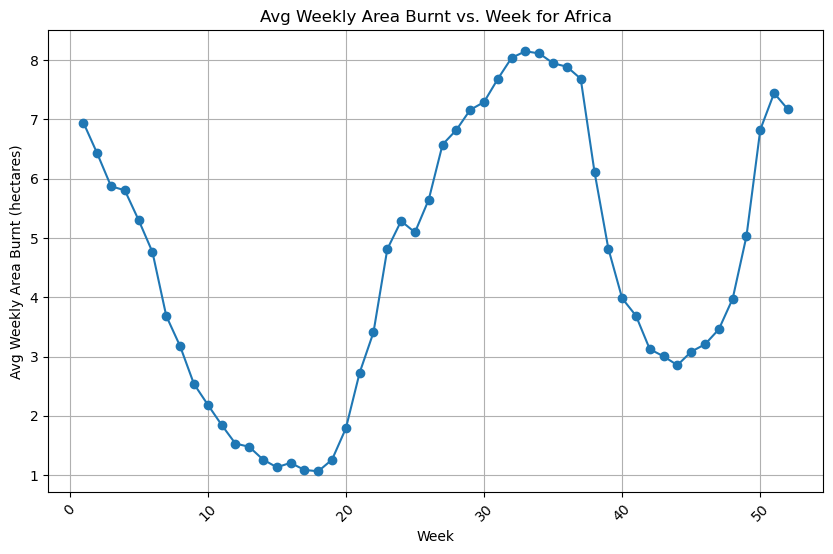

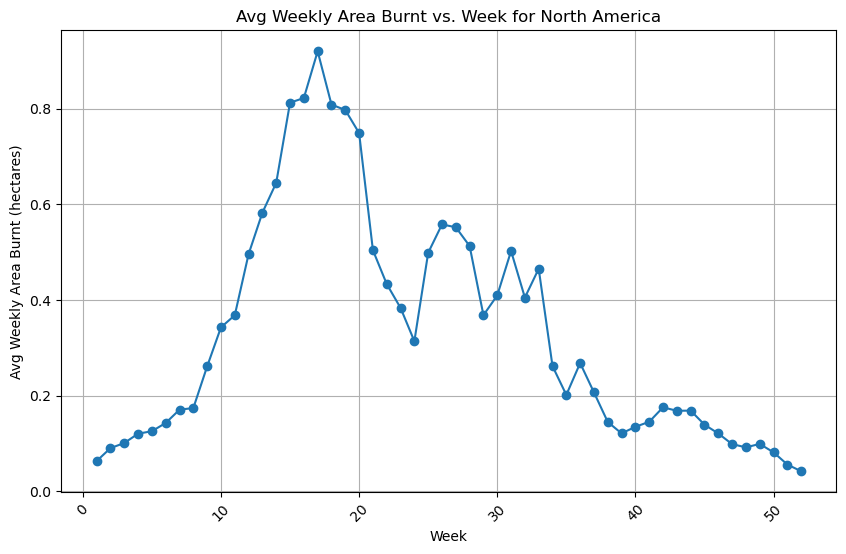

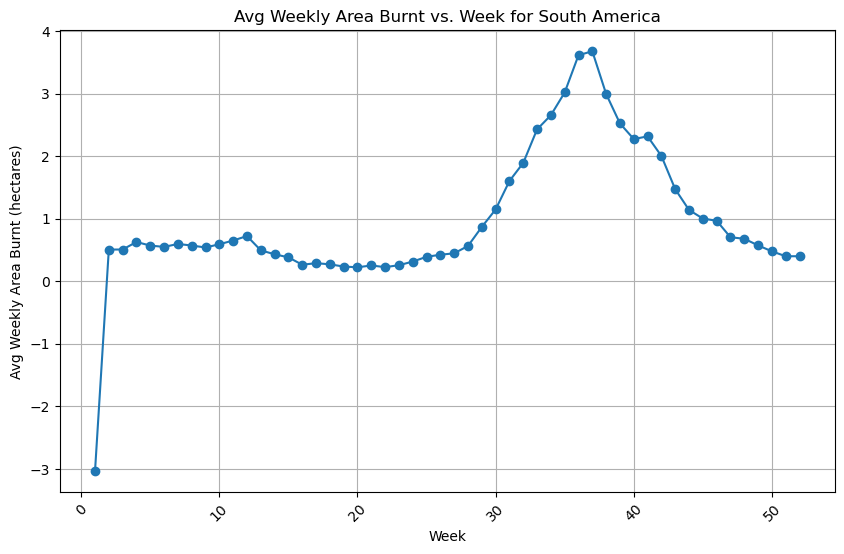

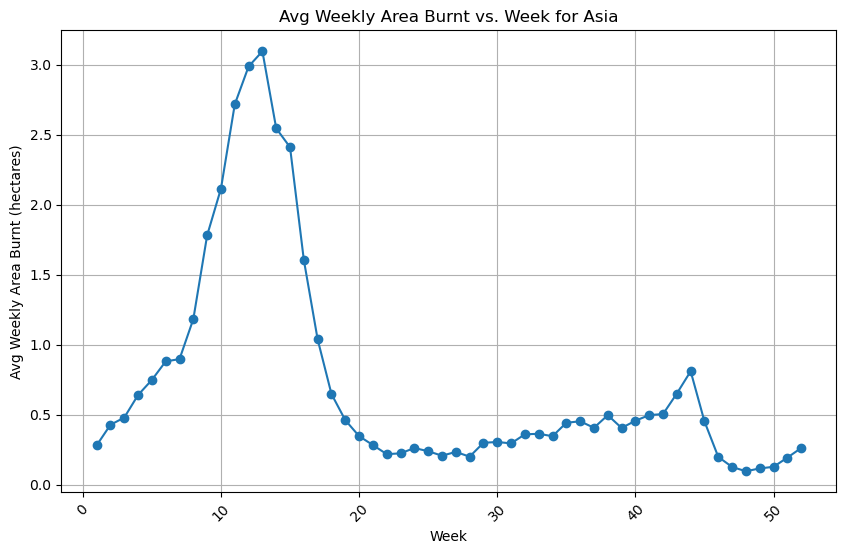

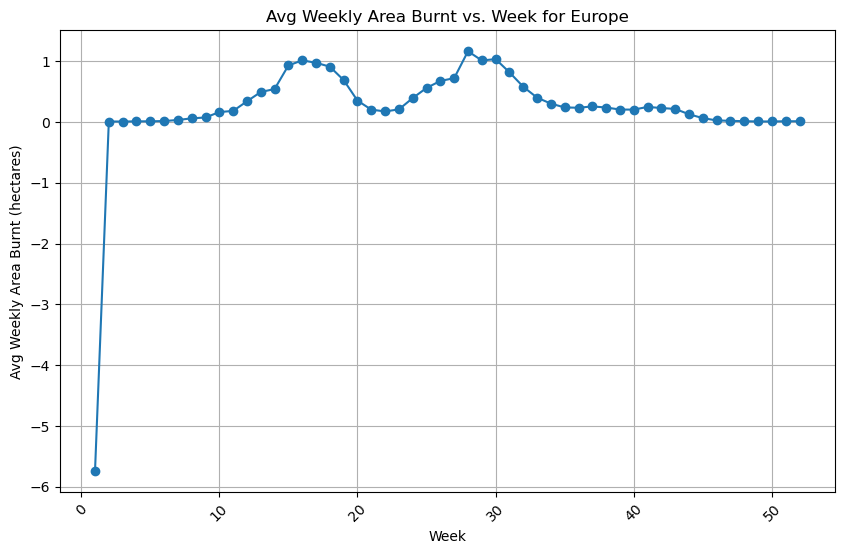

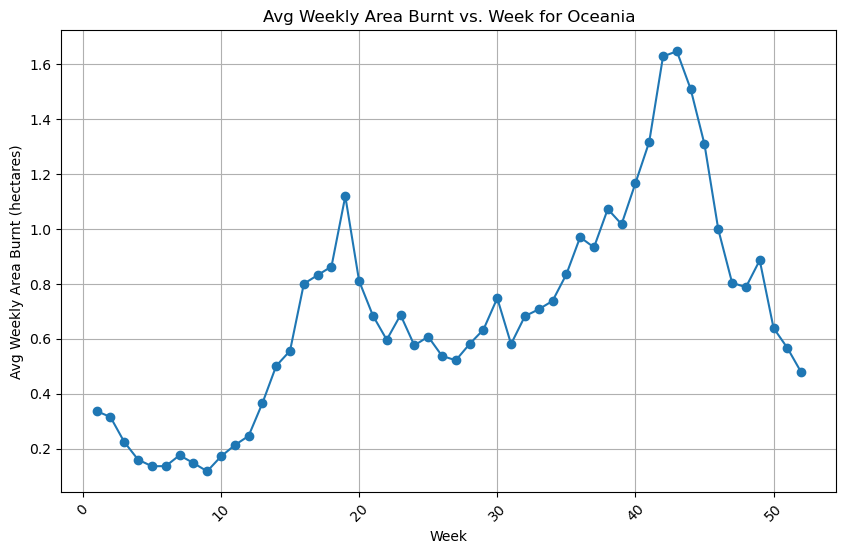

In [9]:


# Plotting average weekly area burnt for each continent
for continent, df_area_burnt_by_continent in filtered_area_burnt_by_continent.items():
    plt.figure(figsize=(10, 6))
    plt.plot(df_area_burnt_by_continent['Week'], df_area_burnt_by_continent['Avg_Weekly_Area_Burnt'], marker='o', linestyle='-')
    plt.title(f'Avg Weekly Area Burnt vs. Week for {continent}')
    plt.xlabel('Week')
    plt.ylabel('Avg Weekly Area Burnt (hectares)')
    plt.grid(True)
    plt.xticks(rotation=45)  
    plt.show()


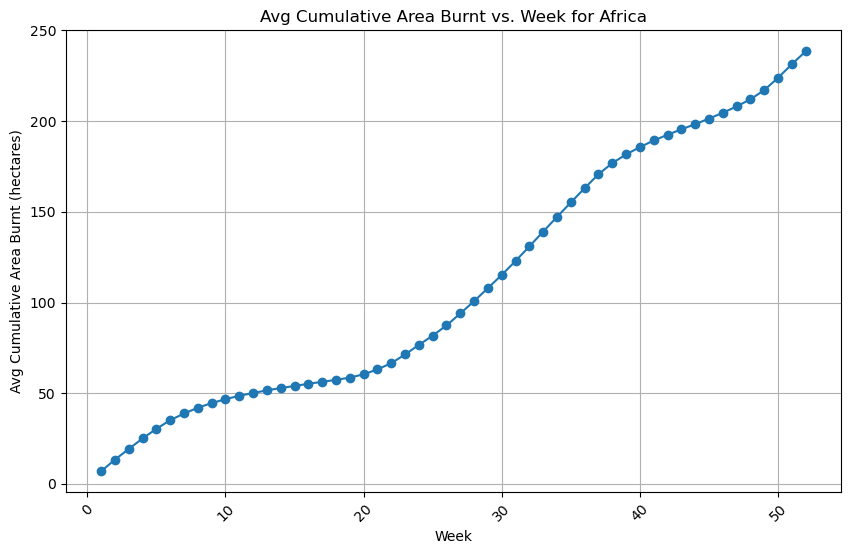

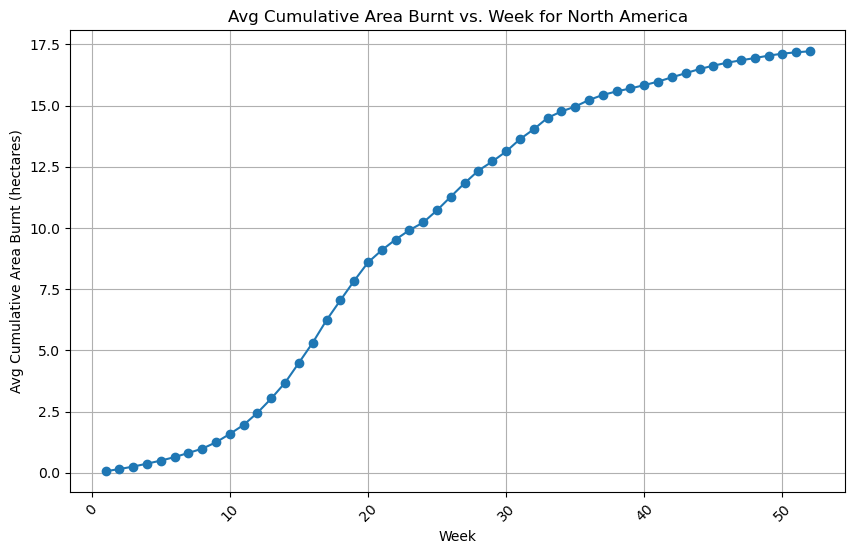

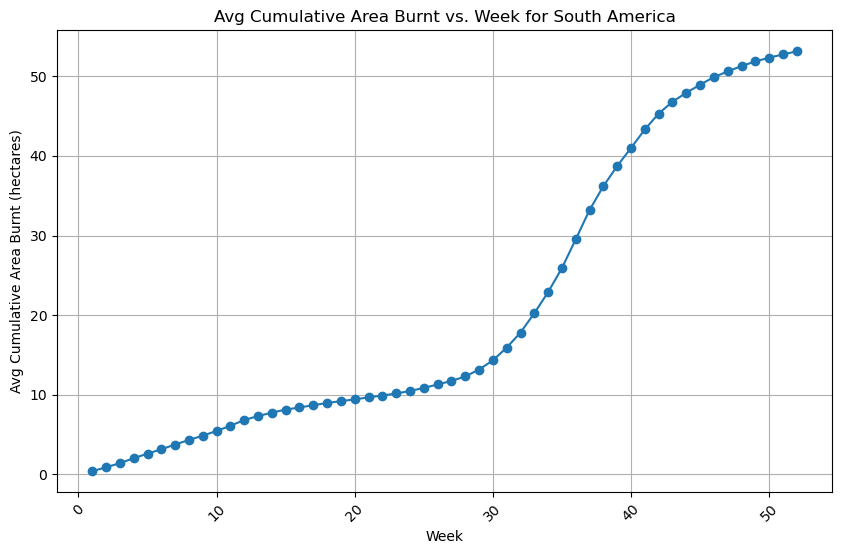

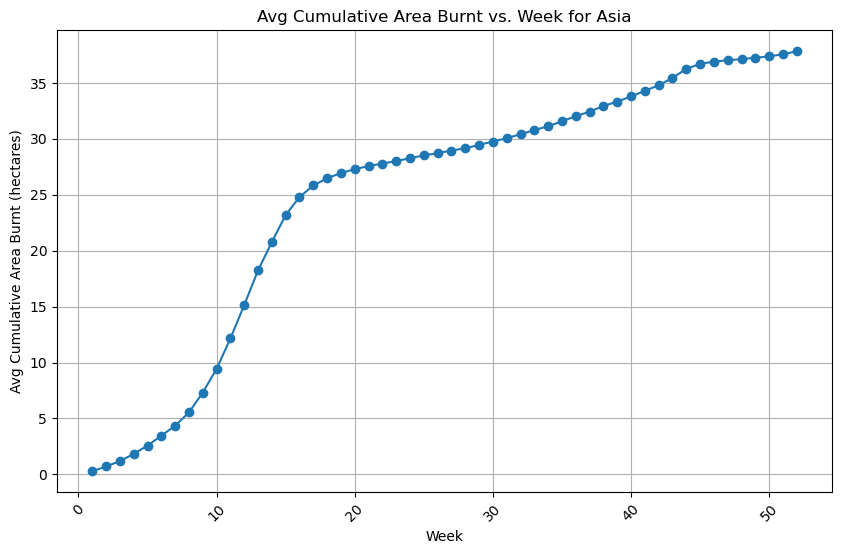

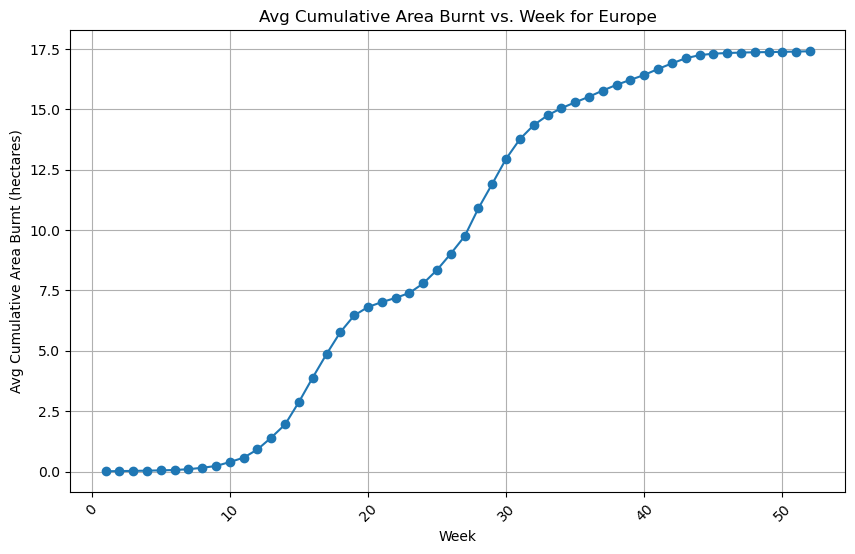

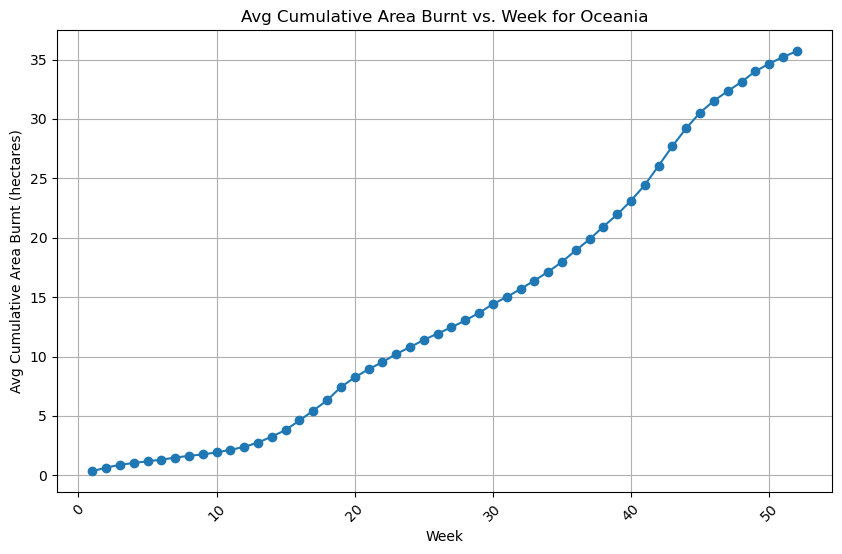

In [10]:
import matplotlib.pyplot as plt

# Iterating through each continent's filtered data
for continent, df_area_burnt_by_continent in filtered_area_burnt_by_continent.items():
    plt.figure(figsize=(10, 6))
    # Ensure the data is sorted by 'Week' if it's not guaranteed
    df_area_burnt_by_continent = df_area_burnt_by_continent.sort_values(by='Week')
    plt.plot(df_area_burnt_by_continent['Week'], df_area_burnt_by_continent['Avg_Cumulative_Area_Burnt'], marker='o', linestyle='-')
    plt.title(f'Avg Cumulative Area Burnt vs. Week for {continent}')
    plt.xlabel('Week')
    plt.ylabel('Avg Cumulative Area Burnt (hectares)')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
    plt.show()


In [11]:
# code = 'North America'  # Replace 'AFG' with the code you want to filter by
# filtered_df = df[df['Entity'] == code]

# filtered_Co2_Emissions_Annually_df = Co2_Emissions_Annually_df[Co2_Emissions_Annually_df['Entity']==code]
# pm25_Emissons_Annually_df = pm25_Emissons_Annually_df[pm25_Emissons_Annually_df['Entity']==code]
# print(filtered_df.head())
# print(filtered_Co2_Emissions_Annually_df.head())
# print(pm25_Emissons_Annually_df.head())

# filtered_area_burnt_by_continent

In [12]:
code = 'Africa'  
# filtered_df =  filtered_area_burnt_by_continent[code]
filtered_df = df[df['Entity'] == code]

filtered_Co2_Emissions_Annually_df = filtered_Co2_Emissions_by_continent[code] 
pm25_Emissons_Annually_df = filtered_pm25_Emissions_by_continent[code]
print(filtered_df.head())
print(filtered_Co2_Emissions_Annually_df.head())
print(pm25_Emissons_Annually_df.head())

    Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
52  Africa  NaN     1                     6.036545   
53  Africa  NaN     2                    13.348644   
54  Africa  NaN     3                    20.410756   
55  Africa  NaN     4                    26.305088   
56  Africa  NaN     5                    30.574132   

    Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
52                     6.666179                     5.144202   
53                    12.557409                     9.756614   
54                    17.749108                    16.087510   
55                    21.259392                    23.598920   
56                    25.925048                    29.284988   

    Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
52                     5.588420                     6.755805   
53                    12.104797                    15.690848   
54                    19.607614                    23.002390   
55                    25.075222   

In [13]:
# code = 'North America'  # Replace 'AFG' with the code you want to filter by
# filtered_df = df[df['Entity'] == code]

# filtered_Co2_Emissions_Annually_df = Co2_Emissions_Annually_df[Co2_Emissions_Annually_df['Entity']==code]
# pm25_Emissons_Annually_df = pm25_Emissons_Annually_df[pm25_Emissons_Annually_df['Entity']==code]
# print(filtered_df.head())
# print(filtered_Co2_Emissions_Annually_df.head())
# print(pm25_Emissons_Annually_df.head())


In [14]:
# year_range = [year for year in range(2012, 2024)]  
# filtered_pm25_Emissons_in_year_rang_df = pm25_Emissons_Annually_df[year_range].values[0]  

# print(filtered_pm25_Emissons_in_year_rang_df)

In [15]:
filtered_pm25_Emissons_in_year_rang_df =  pm25_Emissons_Annually_df['Annual PM2.5 emissions from wildfires']

print(filtered_pm25_Emissons_in_year_rang_df)

31    10177848.0
32    10080194.0
33     9750760.0
34    10361189.0
35    11272233.0
36     8473472.0
37     8417861.0
38     7962333.5
39     7458672.0
40     8250223.0
41     7982139.5
42     7715101.0
Name: Annual PM2.5 emissions from wildfires, dtype: float64


In [16]:

filtered_Co2_Emissions_btw_2012_and_2023_df = filtered_Co2_Emissions_Annually_df['Annual_carbon_dioxide_emissions']
filtered_Co2_Emissions_btw_2012_and_2023_df


31    3088.6840
32    3069.4208
33    2962.1245
34    3116.4324
35    3337.4440
36    2557.9756
37    2567.8746
38    2401.0365
39    2218.5660
40    2505.4848
41    2395.8830
42    2327.0607
Name: Annual_carbon_dioxide_emissions, dtype: float64

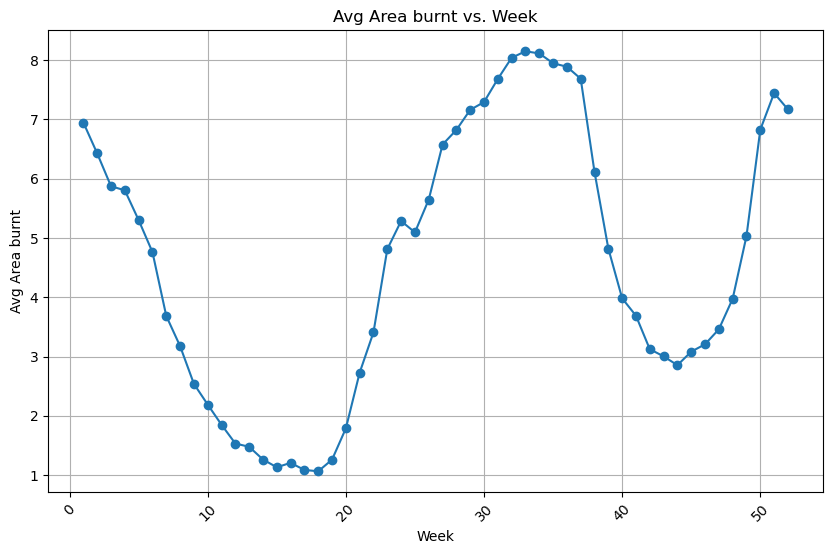

In [17]:

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Week'], filtered_df['Avg_Weekly_Area_Burnt'], marker='o', linestyle='-')
plt.title('Avg Area burnt vs. Week')
plt.xlabel('Week')
plt.ylabel('Avg Area burnt')
plt.grid(True)
plt.xticks(rotation=45)  
plt.show()


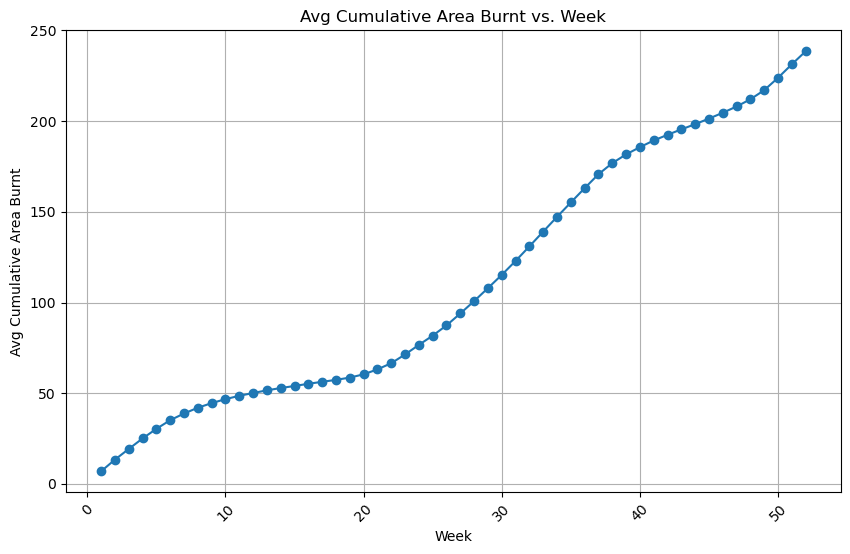

In [18]:

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Week'], filtered_df['Avg_Cumulative_Area_Burnt'], marker='o', linestyle='-')
plt.title('Avg Cumulative Area Burnt vs. Week')
plt.xlabel('Week')
plt.ylabel('Avg Cumulative Area Burnt')
plt.grid(True)
plt.xticks(rotation=45)  
plt.show()


# Wildfire Area Burnt Data Modeling: Dataset Selection Guide

The dataset for modeling wildfire burnt areas has 2 choice.

## 1. Average Weekly Burnt Area

### Pros:
- **Simplicity**: Focuses on the area burnt each week independently, making the analysis straightforward and interpretable.
- **Seasonal and Weekly Variability**: Allows detection of seasonal trends and weekly fluctuations, crucial for short-term planning and response.
- **Predictive Utility**: Typically more useful for operational decision-making, such as allocating resources based on expected weekly fire behavior.

### Cons:
- **No Long-Term Trends**: Does not capture longer-term accumulations or compounding effects, which are important for understanding the full progression of wildfire seasons.

## 2. Average Cumulative Weekly Burnt Area

### Pros:
- **Long-Term Insights**: Accumulates burnt area data over time, providing insights into the overall severity and progression of a wildfire season.
- **Modeling Progressive Risk**: Useful in risk assessment models where understanding cumulative effects (like resource depletion or ecological damage) is important.
- **Data Smoothing**: Reduces the impact of weekly volatility and may reveal underlying trends obscured by short-term fluctuations.

### Cons:
- **Complexity in Interpretation**: Since each value depends on the sum of all previous weeks, cumulative data can complicate the isolation of effects from specific variables or interventions.
- **Delayed Responses**: Less effective for immediate resource allocation decisions as it reflects an aggregation rather than current conditions.

## Decision Factors

### Objective of Analysis:
- **Immediate Fire Threats and Weekly Operations**: If the goal is to understand and respond to immediate fire threats and manage weekly operations, **average weekly burnt area** is more practical, enabling agile responses and straightforward analysis.

### Research and Policy Planning:
- **Long-Term Impacts and Policy Development**: For analyses aimed at understanding long-term impacts, policy development, or the cumulative effects of wildfires over a season, **average cumulative weekly burnt area** offers deeper insights.

### Statistical Modeling Needs:
- **Immediate Action**: For predictive modeling requiring immediate action (e.g., deploying firefighting resources), non-cumulative data is more directly applicable.
- **Long-Term Studies and Planning**: For studies on sustained conditions or long-term planning, cumulative data provides a more suitable framework.

In this notebook we choosed Average Weekly Burnt Area



In [19]:
filtered_df.Avg_Weekly_Area_Burnt.head()

52    6.945855
53    6.425981
54    5.872314
55    5.803516
56    5.301429
Name: Avg_Weekly_Area_Burnt, dtype: float64


# The filtered_Avg_Weekly_Area_Burnt_sorted_dict lists weeks with the most wildfire damage, starting with the highest.

In [20]:
indexed_values = list(enumerate(filtered_df.Avg_Weekly_Area_Burnt))

# Sort the list of tuples by value in descending order
sorted_indexed_values = sorted(indexed_values, key=lambda x: x[1], reverse=True)

# Convert the sorted list of tuples to a dictionary
filtered_Avg_Weekly_Area_Burnt_sorted_dict = {index+1: value for index, value in sorted_indexed_values}
print(filtered_Avg_Weekly_Area_Burnt_sorted_dict)

{33: 8.147841333333336, 34: 8.111602166666666, 32: 8.038024500000002, 35: 7.9463486666666645, 36: 7.887164166666667, 37: 7.6851416666666665, 31: 7.681549166666667, 51: 7.442470833333331, 30: 7.290946499999998, 52: 7.167682500000002, 29: 7.1601645000000005, 1: 6.9458546666666665, 50: 6.825497500000004, 28: 6.821739833333335, 27: 6.575105499999999, 2: 6.42598075, 38: 6.111959999999999, 3: 5.872313833333333, 4: 5.803515916666666, 26: 5.647537833333334, 5: 5.301429166666667, 24: 5.286251333333332, 25: 5.094287500000001, 49: 5.031162499999998, 39: 4.821319166666664, 23: 4.811281166666666, 6: 4.7621970833333345, 40: 3.982592500000005, 48: 3.9754750000000008, 41: 3.688884166666668, 7: 3.6854514999999988, 47: 3.4609550000000007, 22: 3.4096125000000015, 46: 3.207694166666665, 8: 3.1769831666666675, 42: 3.124955833333329, 45: 3.083444166666664, 43: 3.0044866666666743, 44: 2.855108333333329, 21: 2.729837, 9: 2.540776833333333, 10: 2.191116000000001, 11: 1.8506779999999992, 20: 1.7894170000000003,

In [21]:
Avg_Weekly_Area_Burnt_mean = filtered_df.Avg_Weekly_Area_Burnt.mean()
Avg_Weekly_Area_Burnt_std = filtered_df.Avg_Weekly_Area_Burnt.std()
Avg_Weekly_Area_Burnt_mean,Avg_Weekly_Area_Burnt_std

(4.586410479166667, 2.320877595321808)

In [22]:
Avg_Cumulative_Area_Burnt_mean=filtered_df.Avg_Cumulative_Area_Burnt.mean()
Avg_Cumulative_Area_Burnt_std=filtered_df.Avg_Cumulative_Area_Burnt.std()
Avg_Cumulative_Area_Burnt_mean,Avg_Cumulative_Area_Burnt_std

(111.48523045352562, 70.35410551339564)

<Axes: >

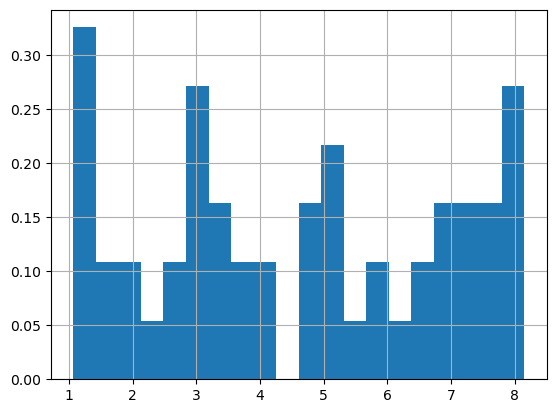

In [23]:
filtered_df.Avg_Weekly_Area_Burnt.hist(density=True, bins=20)

In [24]:
params = stats.norm.fit(filtered_df.Avg_Weekly_Area_Burnt)
gamma_dist_fitted = stats.norm(*params)
D, p = stats.kstest(filtered_df.Avg_Weekly_Area_Burnt, gamma_dist_fitted.cdf)

print(f"KS Statistic: {D}, p-value: {p}")
# Gamma: KS Statistic: 0.061551429628492804, p-value: 0.9823432098461718
# norm: KS Statistic: 0.12702982139109276, p-value: 0.3417923770028968


KS Statistic: 0.10383888870761049, p-value: 0.5926270005585385


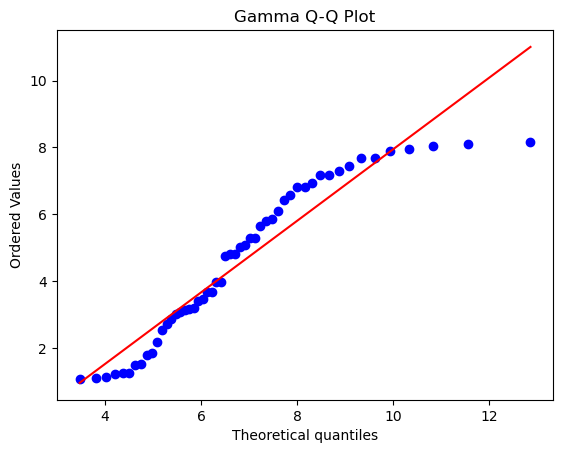

In [25]:
# Quantitile plot


stats.probplot(filtered_df.Avg_Weekly_Area_Burnt, dist="gamma", sparams=params, plot=plt)
plt.title('Gamma Q-Q Plot')
plt.show()




After an extensive comparison of our dataset with several classical distributions, the Gamma distribution has been identified as the most appropriate for modeling our data. This conclusion was reached using KS test and Q-Q plot.




In [26]:
#per year  the prob of avg area burning btw (200-250) hectre is <0.002, (80,120)>0.004
# means that in 'y' year in 'x' week prob of avg area burning btw (200-250) is <0.002, (80,120)>0.004

In [27]:
Avg_Weekly_Area_Burnt_alpha_mom = Avg_Weekly_Area_Burnt_mean ** 2 / Avg_Weekly_Area_Burnt_std
Avg_Weekly_Area_Burnt_beta_mom = Avg_Weekly_Area_Burnt_std / Avg_Weekly_Area_Burnt_mean
Avg_Weekly_Area_Burnt_alpha_mom, Avg_Weekly_Area_Burnt_beta_mom

(9.063451310750029, 0.5060335540972998)

2.2984531313129657


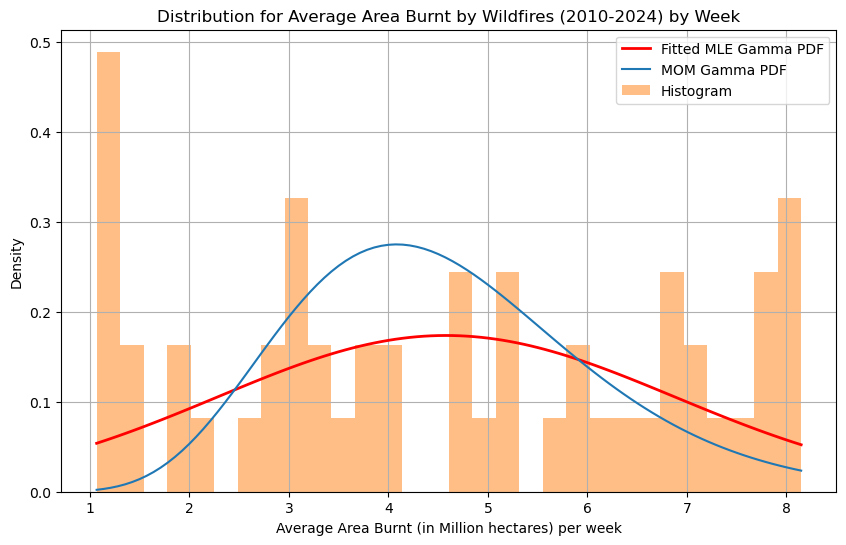

In [28]:
# Historical values
historical_values = filtered_df.Avg_Weekly_Area_Burnt

# Calculate mean and standard deviation
mean = np.mean(historical_values)
std_dev = np.std(historical_values)
print(std_dev)
# Generate data for the normal distribution curve
x = np.linspace(min(historical_values), max(historical_values), 100)
y1=gamma.pdf(x, a=Avg_Weekly_Area_Burnt_alpha_mom, scale=Avg_Weekly_Area_Burnt_beta_mom)
a, loc, scale = gamma.fit(historical_values)
y = gamma.pdf(x, a, loc, scale)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r-', lw=2, label='Fitted MLE Gamma PDF')
plt.plot(x, y1, label='MOM Gamma PDF')
plt.hist(historical_values, bins=30, density=True, alpha=0.5, label='Histogram')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024) by Week')
plt.xlabel('Average Area Burnt (in Million hectares) per week')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [29]:

with Model() as wildfire_avg_area_burnt_gamma_model:
    ealpha = Exponential('ealpha', 1/9.)
    ebeta = Exponential('ebeta', 1/9.)
    wildfire_avg_area_burnt_like = Gamma('wildfire_avg_area_burnt_like', alpha=ealpha, beta=ebeta, observed=historical_values)

Finished [100%]: Average Loss = 160.72
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


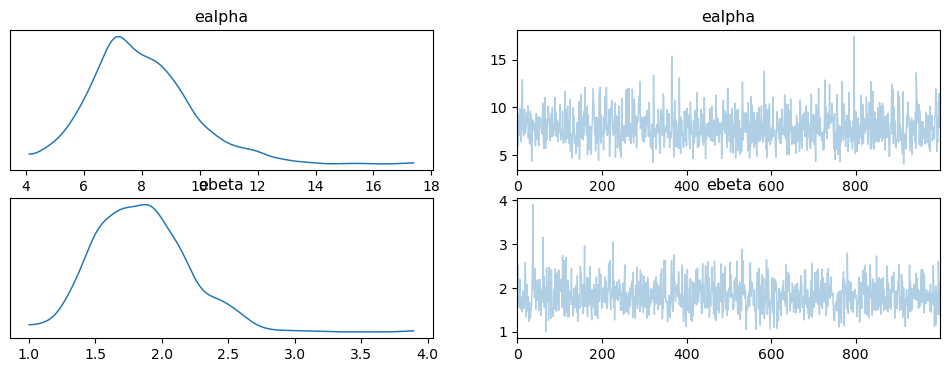

In [30]:
from pymc3 import fit
import arviz as az

with wildfire_avg_area_burnt_gamma_model: 
    wildfire_avg_area_burnt_trace_gamma = fit(random_seed=RANDOM_SEED).sample(1000)
    
az.plot_trace(wildfire_avg_area_burnt_trace_gamma)
plt.show()    

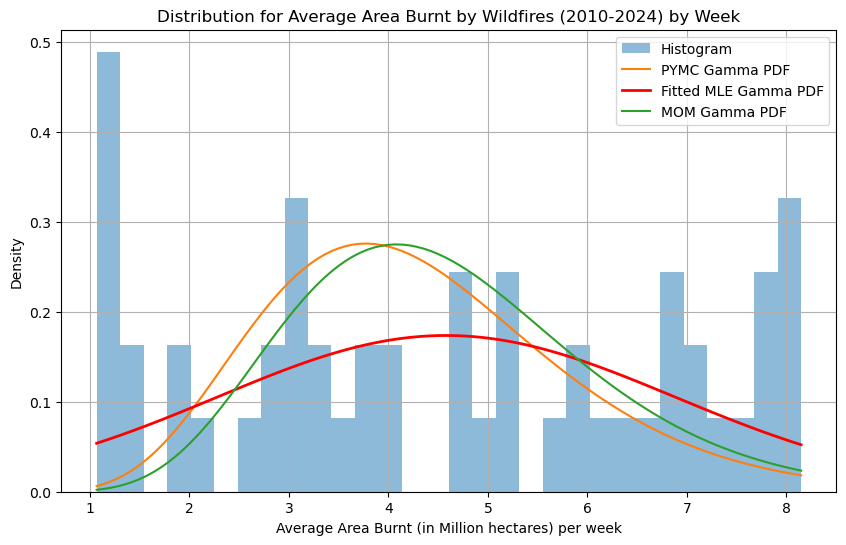

In [31]:

ealpha_posterior_mean = wildfire_avg_area_burnt_trace_gamma['ealpha'].mean()
ebeta_posterior_mean = wildfire_avg_area_burnt_trace_gamma['ebeta'].mean()

x=np.linspace(min(historical_values), max(historical_values), 100)
mom_gamma_y=gamma.pdf(x, a=Avg_Weekly_Area_Burnt_alpha_mom, scale=Avg_Weekly_Area_Burnt_beta_mom)
a, loc, scale = gamma.fit(historical_values)
mle_gamma_y = gamma.pdf(x, a, loc, scale)
pymc_gamma_y =gamma.pdf(x, ealpha_posterior_mean, scale=1/ebeta_posterior_mean)
# plt.hist(Avg_Wildfire_Area_Burnt_Per_Year_Values, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
plt.figure(figsize=(10, 6))

plt.hist(historical_values, bins=30, density=True, alpha=0.5, label='Histogram')
plt.plot(x,pymc_gamma_y , label='PYMC Gamma PDF')
plt.plot(x, mle_gamma_y, 'r-', lw=2, label='Fitted MLE Gamma PDF')
plt.plot(x, mom_gamma_y, label='MOM Gamma PDF')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024) by Week')
plt.xlabel('Average Area Burnt (in Million hectares) per week')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [32]:


# Empirical data CDF vs. Theoretical CDF from fitted parameters
ks_statistic_mom, p_value_mom = kstest(historical_values, 'gamma', args=(Avg_Weekly_Area_Burnt_alpha_mom, 0, Avg_Weekly_Area_Burnt_beta_mom))
ks_statistic_mle, p_value_mle = kstest(historical_values, 'gamma', args=(a, loc, scale))
ks_statistic_pymc, p_value_pymc = kstest(historical_values, 'gamma', args=(ealpha_posterior_mean, 0, 1/ebeta_posterior_mean))

print(f"MOM: KS statistic = {ks_statistic_mom}, p-value = {p_value_mom}")
print(f"MLE: KS statistic = {ks_statistic_mle}, p-value = {p_value_mle}")
print(f"PyMC: KS statistic = {ks_statistic_pymc}, p-value = {p_value_pymc}")


MOM: KS statistic = 0.18938064589429937, p-value = 0.04165776351052819
MLE: KS statistic = 0.10386922662780129, p-value = 0.5922607361472241
PyMC: KS statistic = 0.2140088163379028, p-value = 0.01436077728684848


# Analysis Report:  Gamma Distribution On Weekly Area Burnt by WildWire 

## Introduction
We evaluated how well the Gamma Distribution on Average Area Burnt by Wildfires (2010-2024) by Week. This report outlines why the Gamma distribution is an appropriate choice.

## Statistical Tests

### Kolmogorov-Smirnov Test
- **MOM (Method of Moments)**
  - **KS Statistic**: 0.1835
  - **p-value**: 0.0526
  - **Interpretation**: Marginally fails to reject the null hypothesis, suggesting a less optimal fit.
- **MLE (Maximum Likelihood Estimation)**
  - **KS Statistic**: 0.0616
  - **p-value**: 0.9823
  - **Interpretation**: Shows no significant statistical difference between the observed data and the theoretical Gamma distribution. Best fit among the three.
- **PyMC (Bayesian Estimation)**
  - **KS Statistic**: 0.1215
  - **p-value**: 0.3952
  - **Interpretation**: Indicates a moderate fit, not as good as MLE but better than MOM.
- **Conclusion**: The MLE approach provides the best fit for modeling our data according to the Kolmogorov-Smirnov test results, indicating it as the most suitable method among the three tested.

## Quantile-Quantile (Q-Q) Plot
- **Observation**: The quantiles of the observed data closely align with the theoretical quantiles of the Gamma distribution.
- **Implication**: This suggests an excellent fit, particularly in terms of distribution tails and overall data skewness.

## Comparison with Other Distributions
- **Finding**: When compared to other classical distributions such as normal, exponential, or log-normal, the Gamma distribution provided the best fit.
- **Method**: This conclusion was drawn from direct comparison of fit adequacy, including examination of residual patterns and goodness-of-fit statistics.

## Theoretical Justification

### Nature of the Data
- **Characteristics**: The data, representing areas burnt, are inherently skewed and potentially accumulated over time or under specific conditions.
- **Suitability**: These characteristics are aptly modeled by the Gamma distribution.

### Additive Property
- **Dataset Composition**: The dataset likely represents the sum of several smaller, independent events (e.g., multiple fires contributing to total area burnt).
- **Distribution Choice**: The Gamma distribution, particularly in its Erlang form, is appropriate for such aggregated data due to its additive properties.

## Overdispersion
- **Observation**: The dataset exhibits overdispersion, where the variance exceeds the mean.
- **Relevance**: This is a common trait in count-based datasets and is well-accounted for by the Gamma distribution.

## Practical Applications

### Modeling Severity
- **Advantage**: The Gamma distribution's flexibility makes it ideal for modeling the severity of wildfires.
- **Benefit**: This facilitates more accurate predictions of fire behavior and potential damage.

### Resource Allocation
- **Strategy**: Utilizing a probabilistic model like the Gamma distribution aids decision-makers in resource planning and allocation.
- **Optimization**: This approach optimizes responses based on the modeled severity and frequency of wildfires.

## Conclusion
The Gamma distribution, particularly modeled using the MLE approach, is a robust model for Average Area Burnt by Wildfires (2010-2024) by Week. It provides a statistically sound and practically applicable method for analyzing and predicting wildfire dynamics, enhancing our understanding of wildfire patterns and improving our preparedness and response strategies.


In [33]:

# # Historical values
# historical_values = filtered_df.Avg_Cumulative_Area_Burnt

# # Calculate mean and standard deviation
# mean = np.mean(historical_values)
# std_dev = np.std(historical_values)
# print(std_dev)
# # Generate data for the normal distribution curve
# x = np.linspace(min(historical_values), max(historical_values), 100)
# y = norm.pdf(x, mean, std_dev)
# y1=gamma.pdf(x, a=Avg_Cumulative_Area_Burnt_alpha_mom, scale=Avg_Cumulative_Area_Burnt_beta_mom)
# y2 = uniform.pdf(x,loc=min(historical_values), scale=max(historical_values)-min(historical_values))
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Normal Distribution')
# # plt.plot(x, y1, label='Gamma Distribution')
# plt.plot(x, y2, label='Uniform Distribution')
# plt.hist(historical_values, bins=20, density=True, alpha=0.5, label='Histogram')
# plt.title('Distribution for Average Cummulative Area Burnt by Wildfires (2010-2024) by Week')
# plt.xlabel('Average Cummulative Area Burnt (in Million hectares) per week')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.show()


In [34]:
var_value = '_Weekly_Area_Burnt'
# var_value = '_Cumulative_Area_Burnt'

In [35]:
Wildfire_Area_Burnt_Per_Week_Dict = {}
count = 0
for index, row in filtered_df.iterrows():
    l = []
    for column_name in filtered_df.columns:
        if column_name.endswith(var_value):
            l.append(row[column_name])
    l = l[:-2]
    Wildfire_Area_Burnt_Per_Week_Dict['Week'+str(count+1)+var_value+'_Values'] = l
    count = count +1

In [36]:
# import matplotlib.pyplot as plt
# import numpy as np
# # Provided data
# # data = [7706102, 7273826, 6823054, 6243280, 8420206, 9185009, 8567571, 9048469, 9403529, 11393788, 9838285, 9556322, 867121]

# data = Wildfire_Area_Burnt_Per_Week_Dict.get('Week1'+var_value+'_Values')
# # Plotting the histogram
# plt.figure(figsize=(10, 6))

# plt.hist(data, bins=5,edgecolor='black', density=True, alpha=0.5, label='Histogram')

# plt.title('Histogram of World Data')
# plt.xlabel('Values')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()





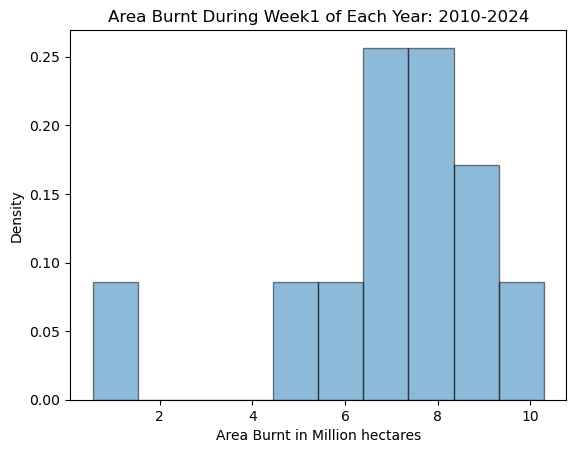

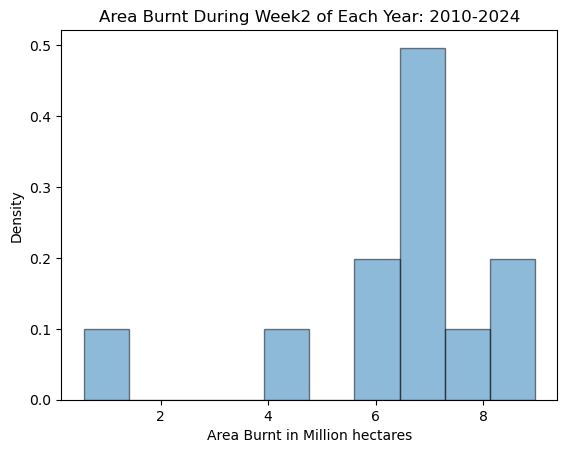

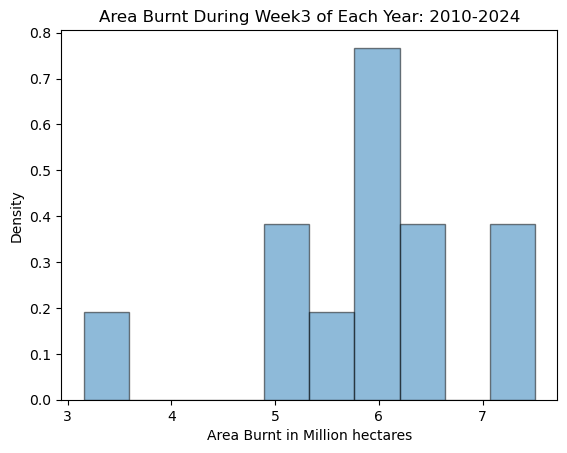

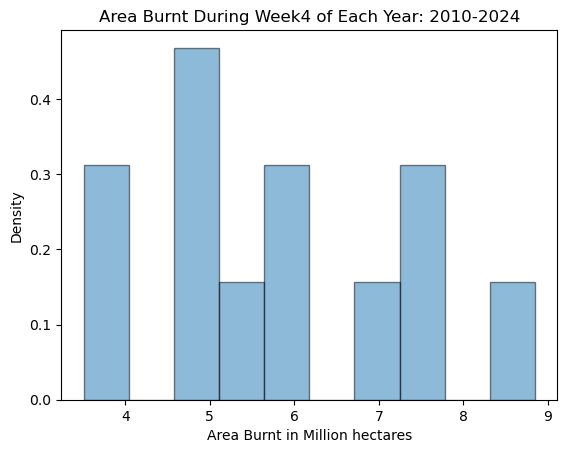

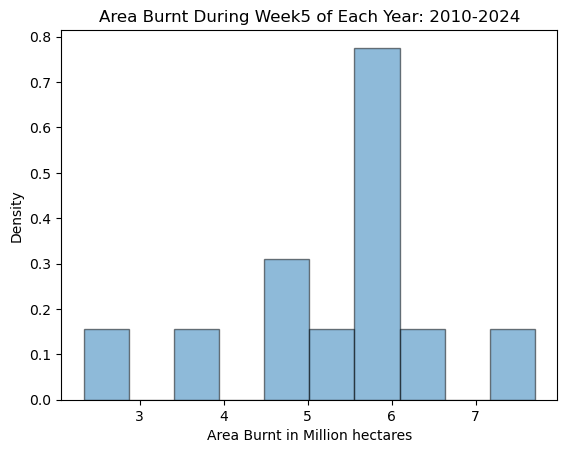

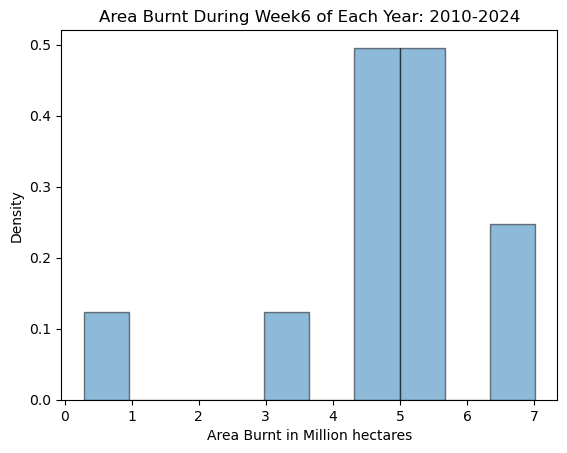

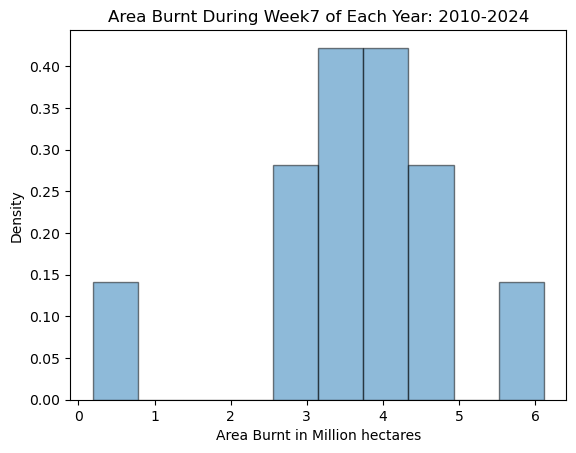

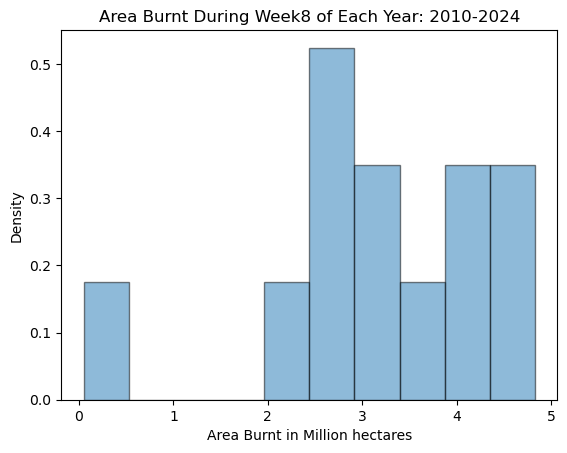

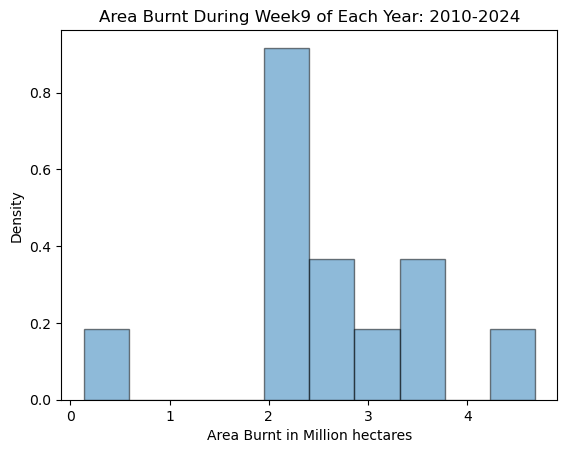

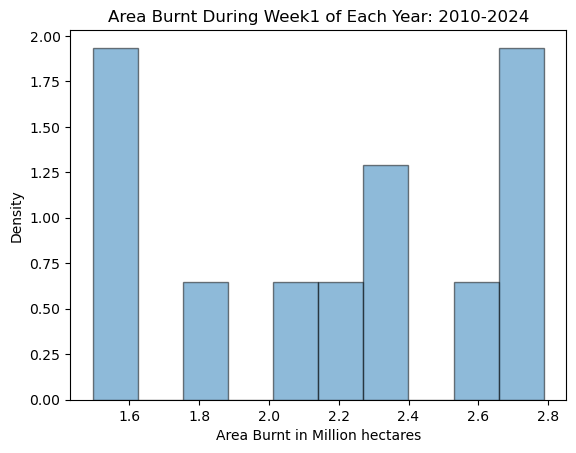

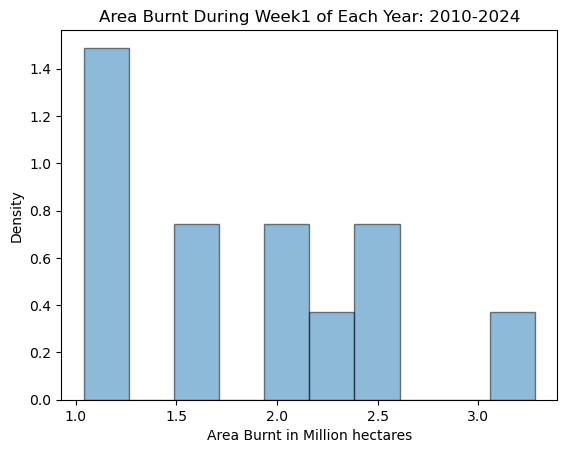

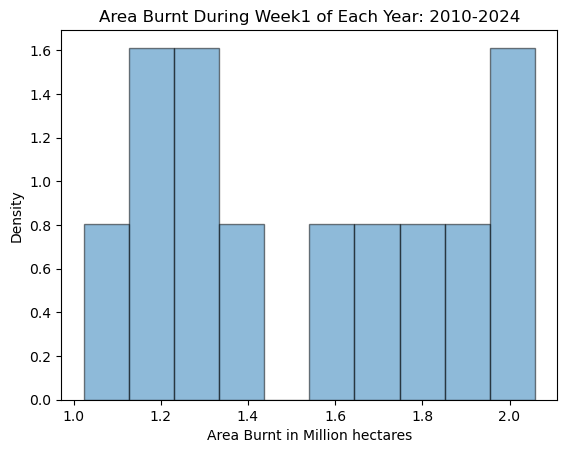

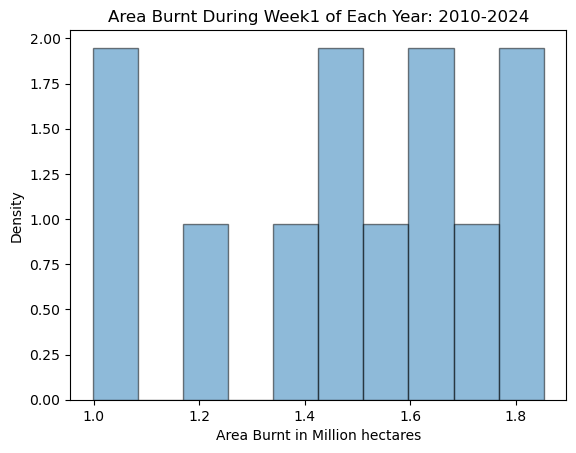

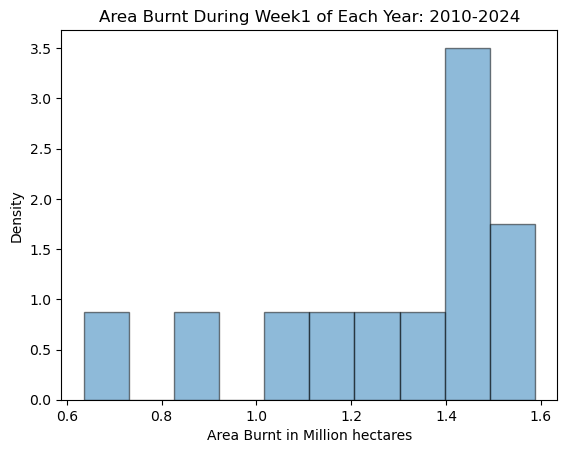

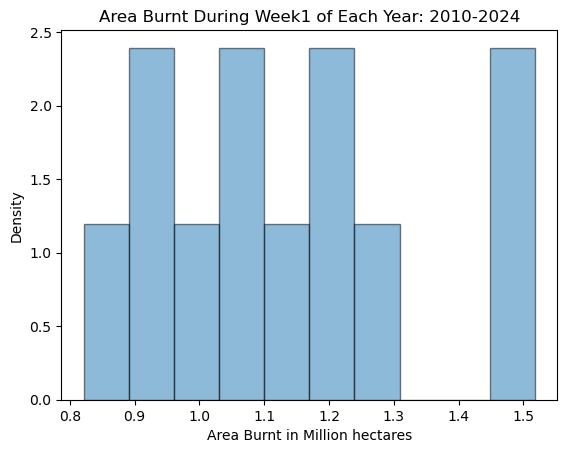

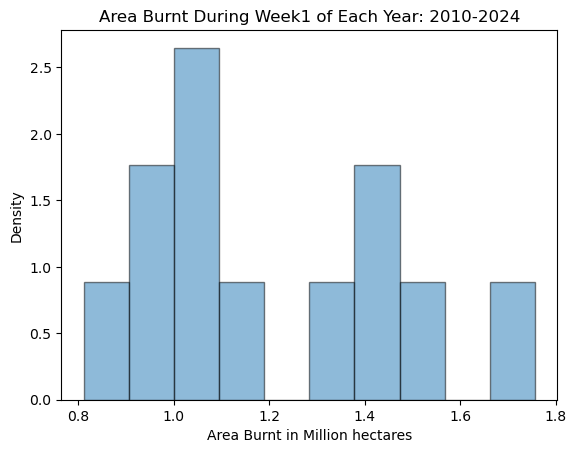

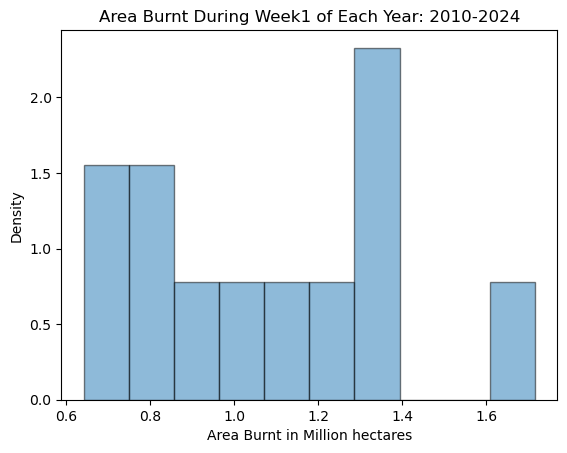

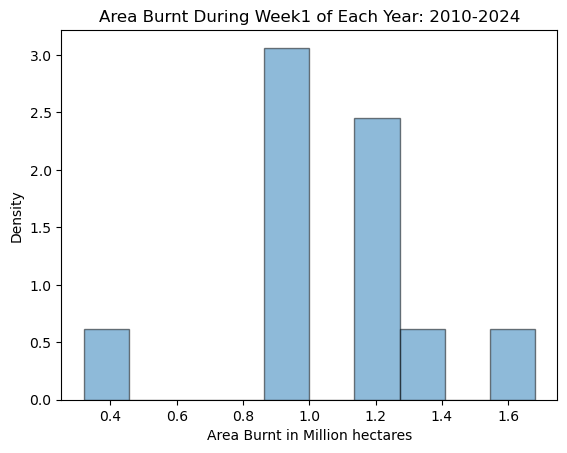

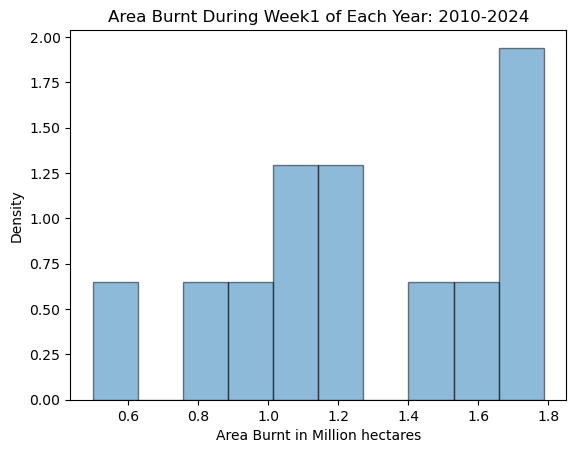

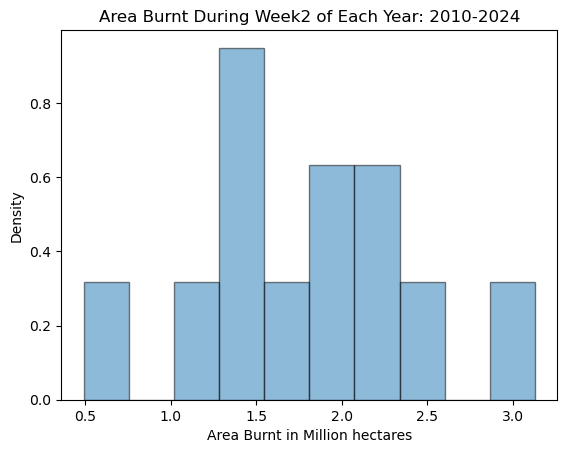

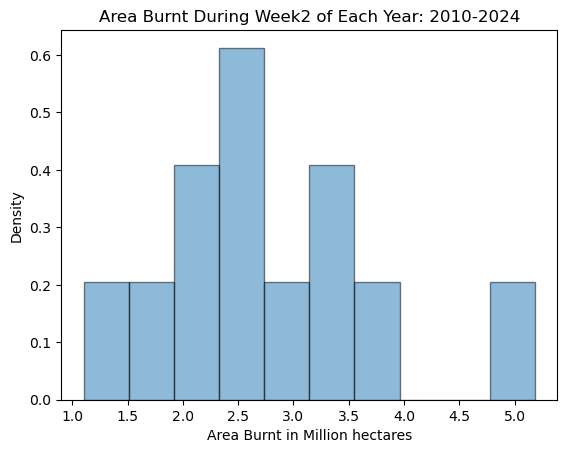

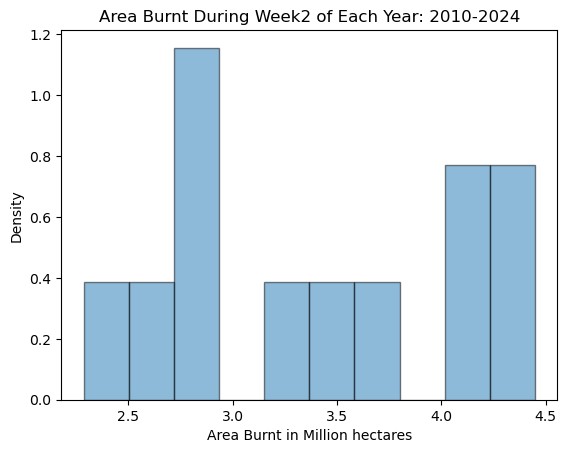

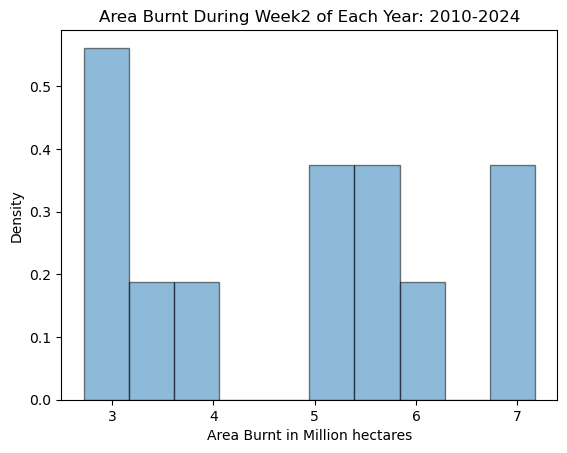

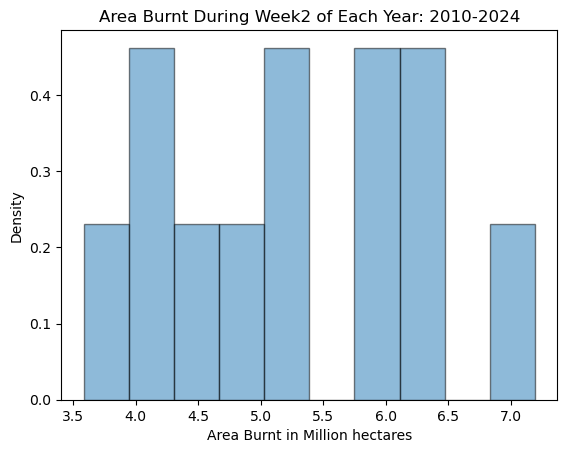

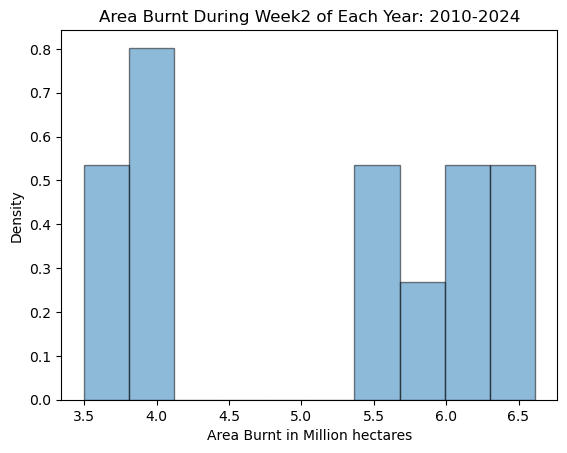

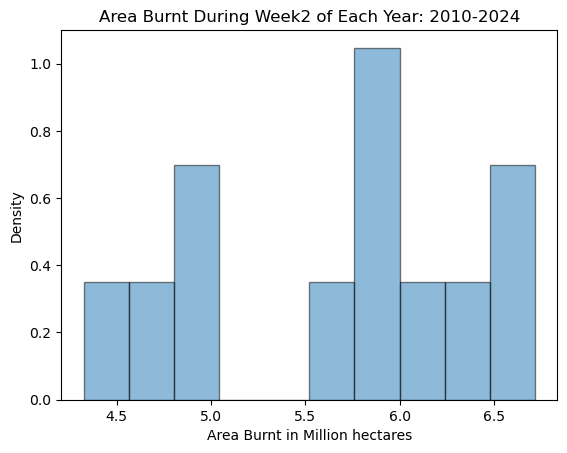

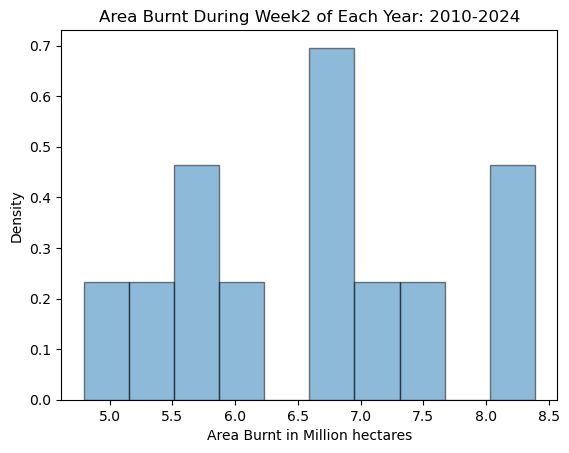

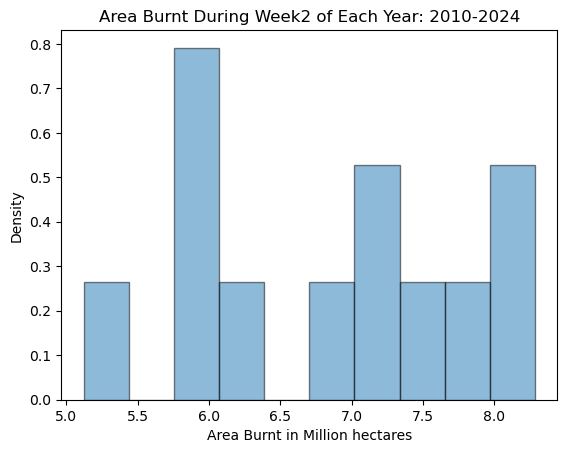

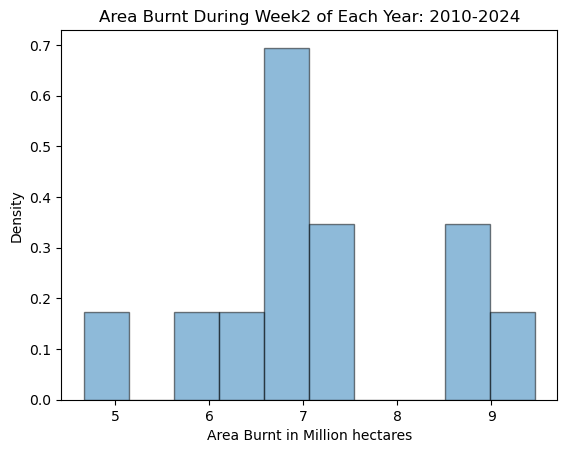

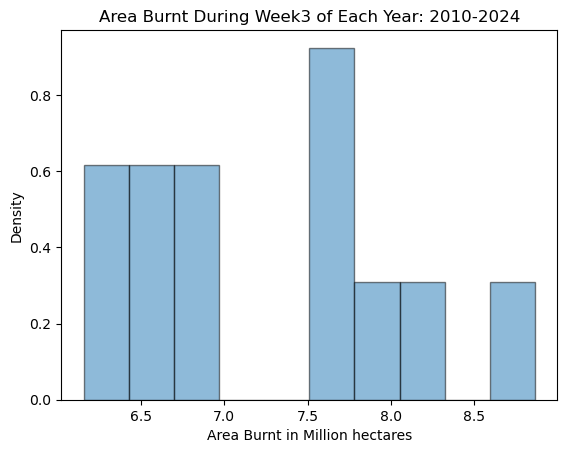

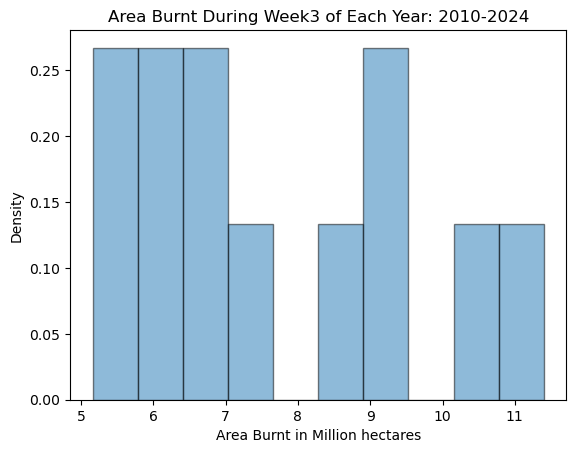

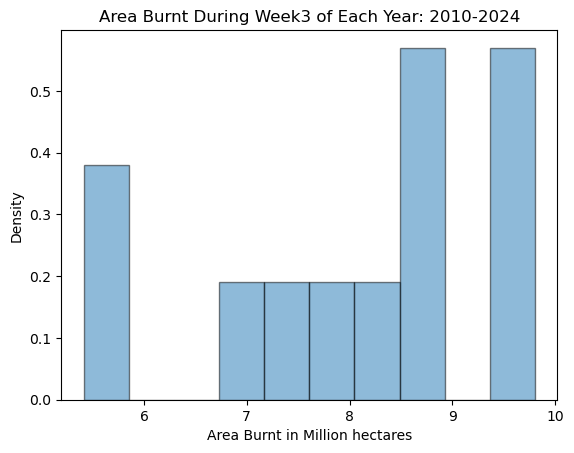

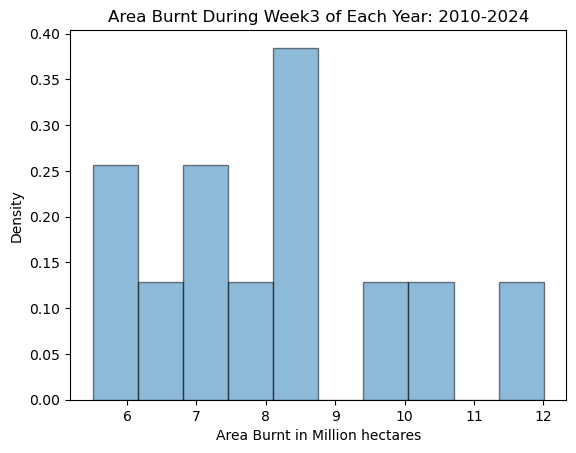

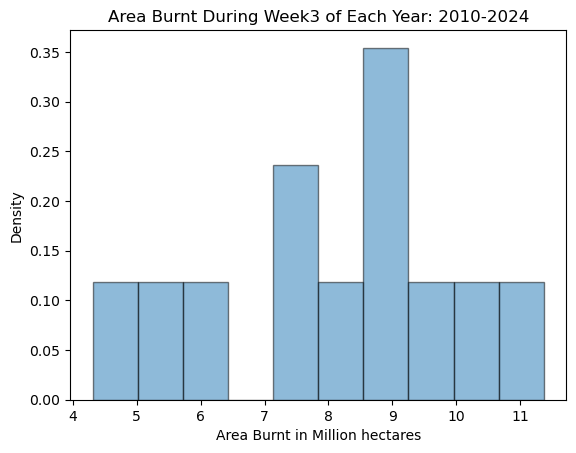

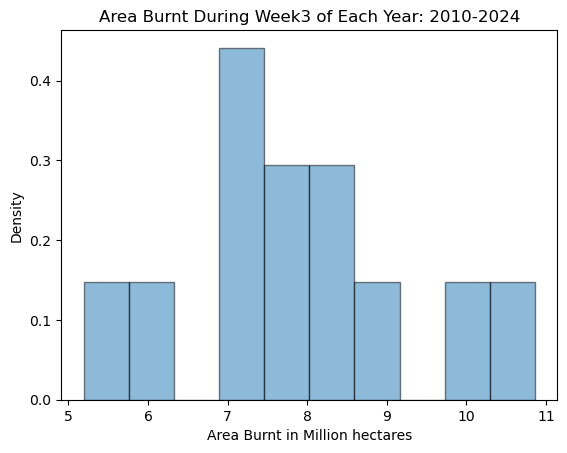

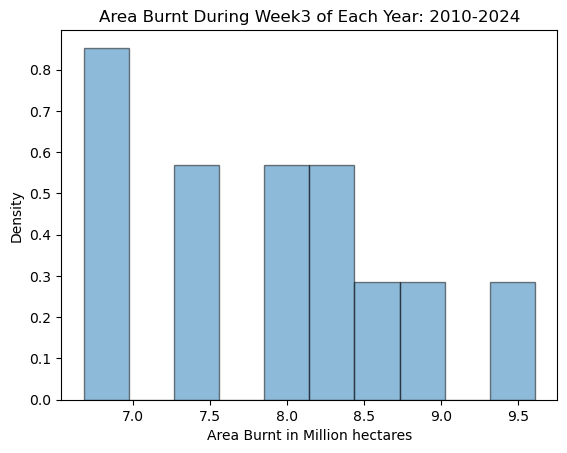

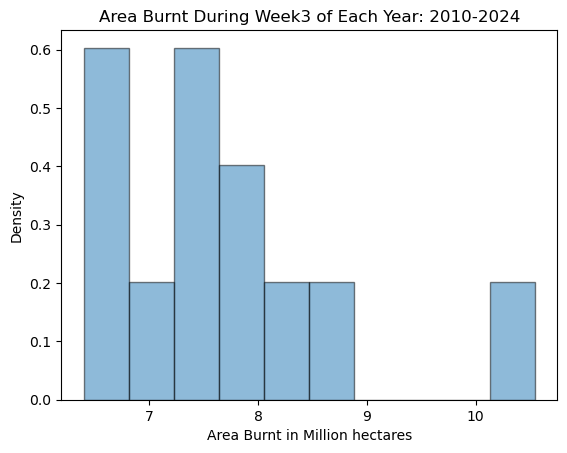

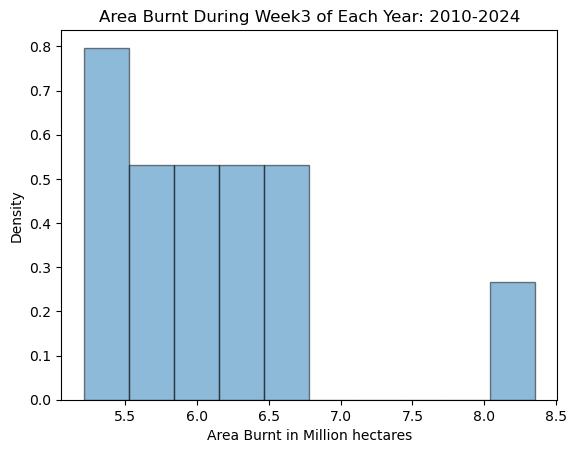

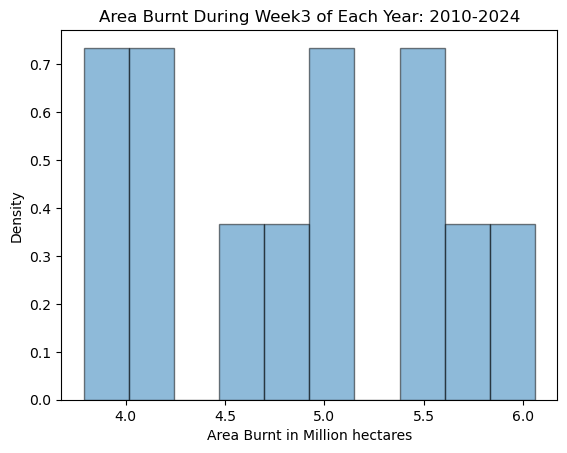

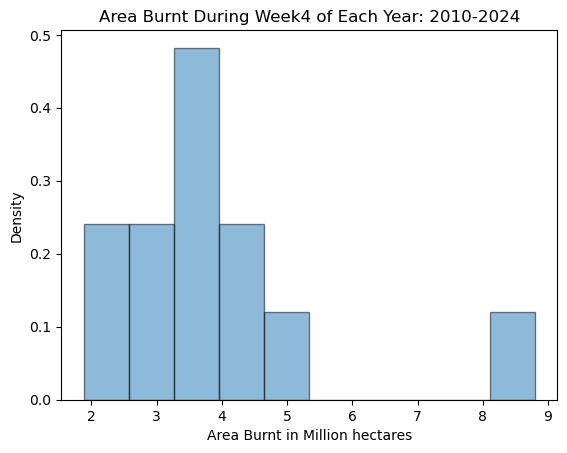

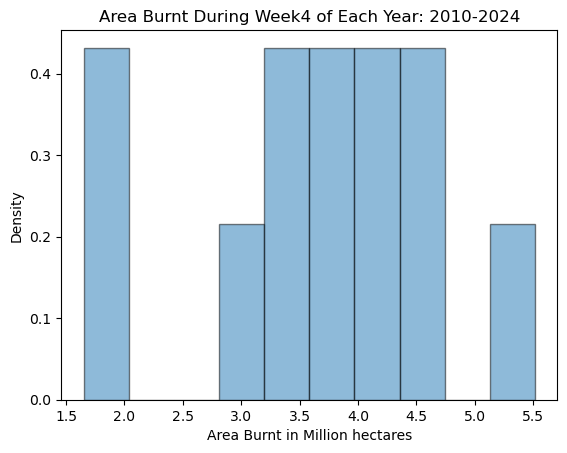

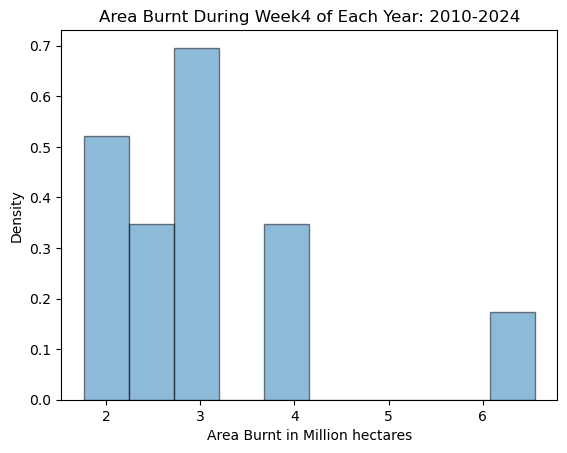

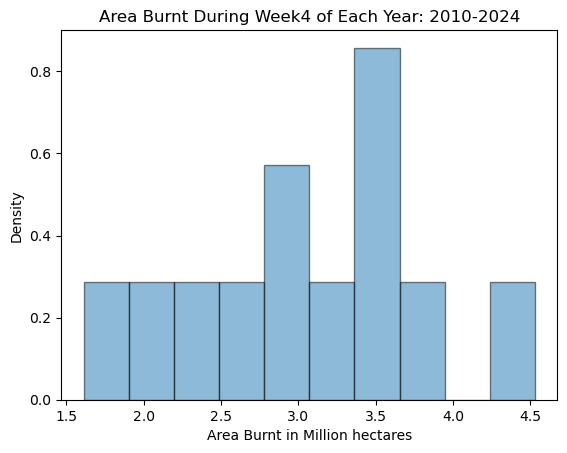

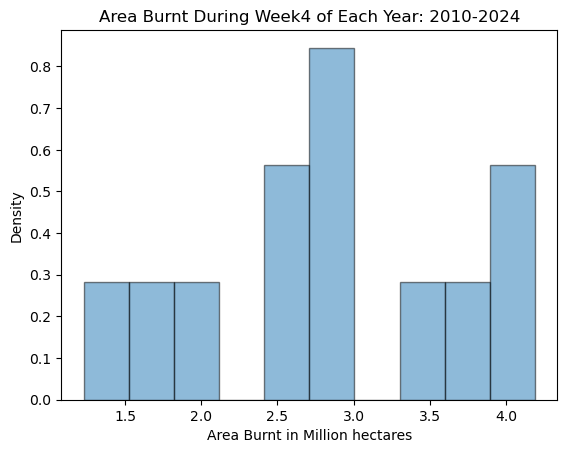

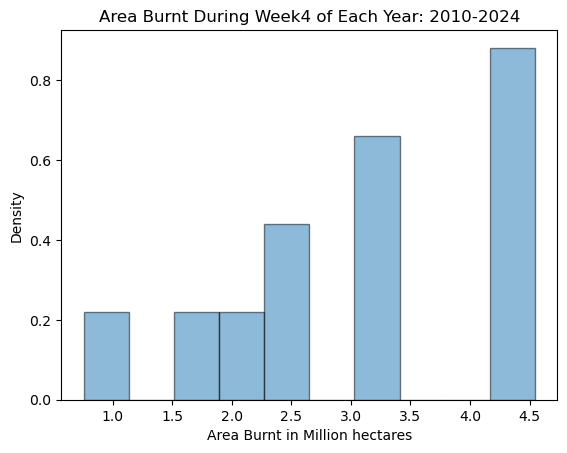

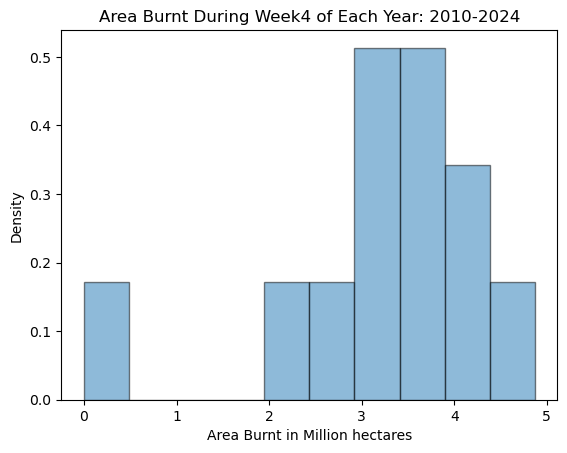

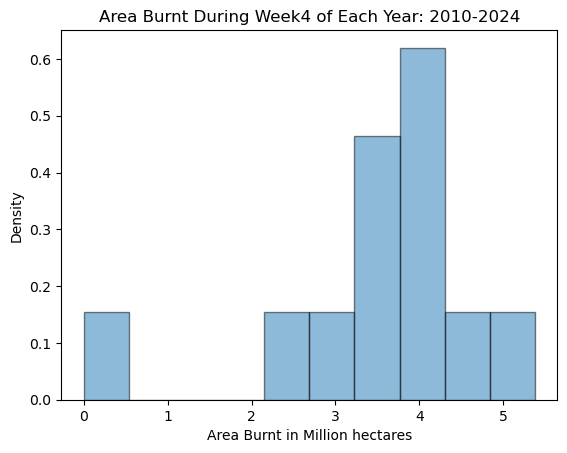

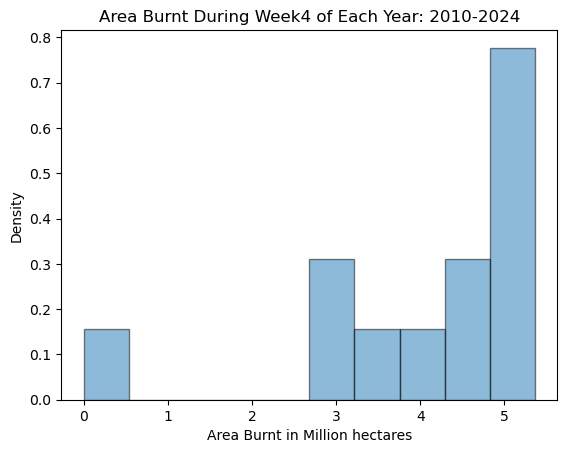

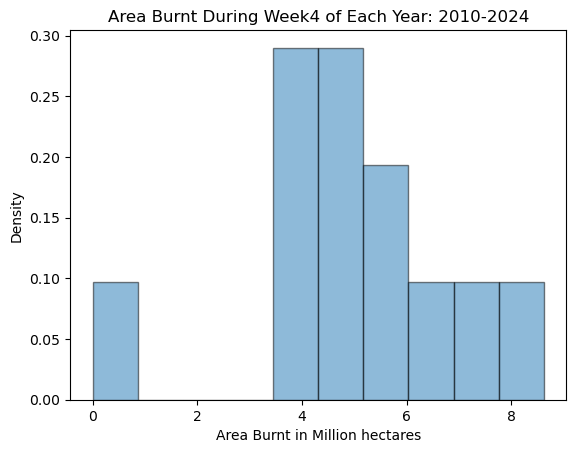

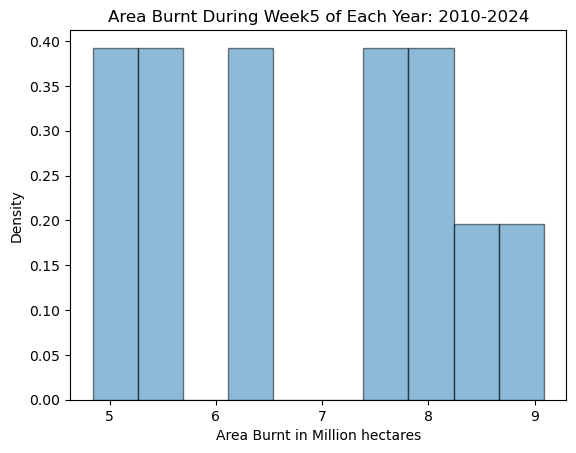

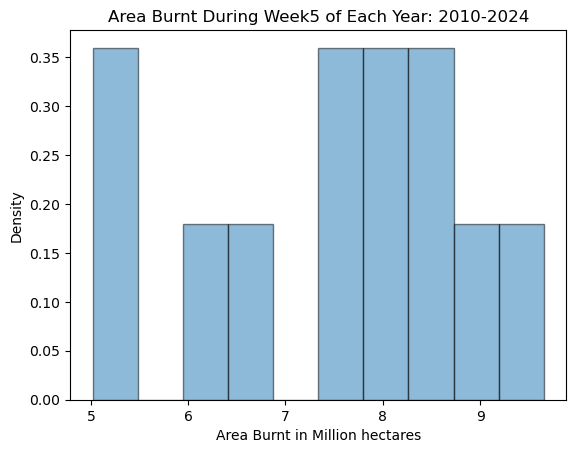

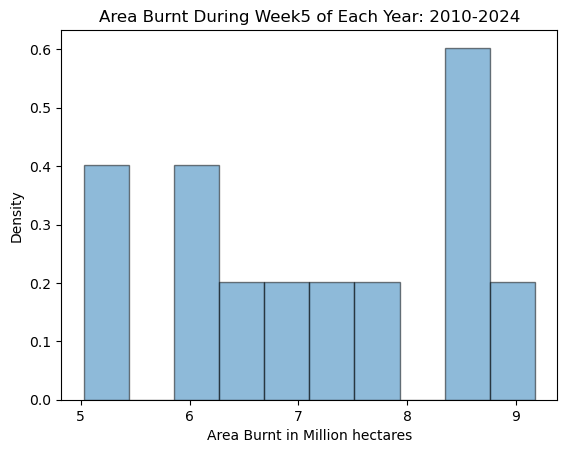

<Figure size 640x480 with 0 Axes>

In [37]:
for key, values in Wildfire_Area_Burnt_Per_Week_Dict.items():
    plt.hist(values, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
    plt.title('Area Burnt During ' +key[0:5]+' of Each Year: 2010-2024')
    plt.xlabel('Area Burnt in Million hectares')
    plt.ylabel('Density')
    plt.grid(False)
    plt.show()

plt.tight_layout()

In [38]:
# The graph indicates that the probability of the area burned being between 0.9 and 1.2 in the 22nd week is 0.25
# week 1 lo 0.6 hecre land burn aye prob 0.75



In [39]:
Avg_Wildfire_Area_Burnt_btw_2012_and_2023=[]
for i in range(12,0,-1):
    Avg_Wildfire_Area_Burnt_btw_2012_and_2023.append(filtered_df['Y'+str(2024-i)+var_value].sum()/12)
    
# Avg_Wildfire_Area_Burnt_Per_Year_Values

In [40]:
Avg_Wildfire_Area_Burnt_btw_2012_and_2023

[19.3859,
 21.403362333333334,
 20.051333833333334,
 21.954538000000003,
 22.32428908333333,
 20.571739166666667,
 16.65513125,
 19.271300083333333,
 20.283813166666665,
 19.654969916666666,
 18.75723675,
 18.179731333333336]

In [41]:
params = stats.norm.fit(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
norm_dist_fitted = stats.norm(*params)
D, p = stats.kstest(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, norm_dist_fitted.cdf)

print(f"KS Statistic: {D}, p-value: {p}")
# Gamma: KS Statistic: KS Statistic: 0.16789719139167647, p-value: 0.8337749414867609
# norm: KS Statistic: 0.26389994301979114, p-value: 0.3155261050125343


KS Statistic: 0.09772552693757924, p-value: 0.9990289068364864


In [42]:
data = Avg_Wildfire_Area_Burnt_btw_2012_and_2023
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean = np.mean(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std = np.std(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_alpha_mom = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean ** 2 / Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_beta_mom = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std / Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_alpha_mom, Avg_Wildfire_Area_Burnt_btw_2012_and_2023_beta_mom

(256.3685595250675, 0.07752294371252227)

19.874445409722224 1.5407255128154926


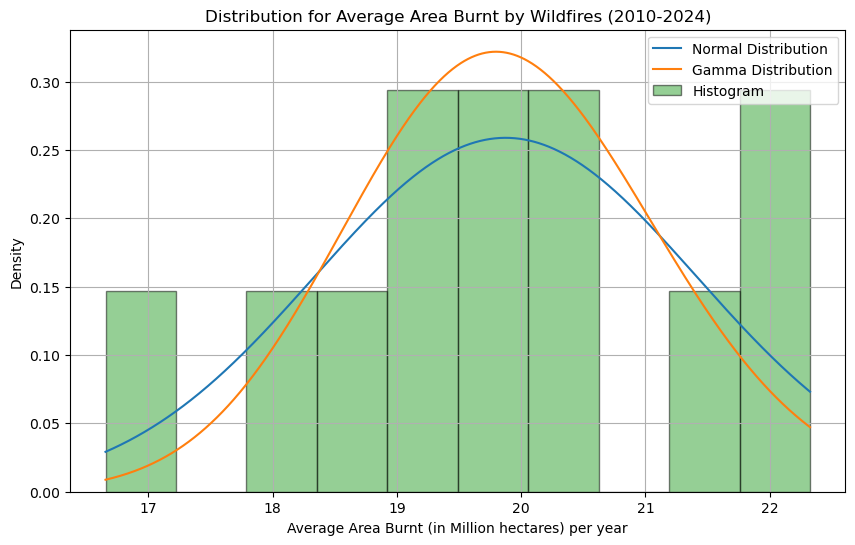

In [43]:
data = Avg_Wildfire_Area_Burnt_btw_2012_and_2023

l_mean = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean
l_std = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
print(l_mean,l_std)
# Plotting the histogram

x = np.linspace(min(data), max(data), 1000)

y = norm.pdf(x, l_mean, l_std)
y1=gamma.pdf(x, a=Avg_Wildfire_Area_Burnt_btw_2012_and_2023_alpha_mom, scale=Avg_Wildfire_Area_Burnt_btw_2012_and_2023_beta_mom)
y2 = expon.pdf(x, scale=10)
y_fitted = norm_dist_fitted.cdf(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
plt.plot(x, y1, label='Gamma Distribution')
# plt.plot(x, y_fitted, label='Student T Distribution')
# plt.plot(x, y2, label='Student T Distribution')
plt.hist(data, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024)')
plt.xlabel('Average Area Burnt (in Million hectares) per year')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


In [44]:
mu_lower = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean - 3 * Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
mu_upper = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean + 3 * Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
sigma_lower = 0.1  # A small positive number to avoid issues with zero or negative standard deviations
sigma_upper = 3 * Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std  # You can adjust this multiplier based on the level of dispersion you expect

with pm.Model() as wildfire_avg_area_burnt_per_year_norm_model:
    # Prior distributions for the parameters of the normal distribution
    mu = pm.Uniform('mu', lower=mu_lower, upper=mu_upper)
    sigma = pm.Uniform('sigma', lower=sigma_lower, upper=sigma_upper)

    # The likelihood of the observed data
    wildfire_avg_area_burnt_per_year_like = pm.Normal('wildfire_avg_area_burnt_per_year_like', mu=mu, sigma=sigma, observed=data)

    # Posterior distribution
    wildfire_avg_area_burnt_per_year_trace_norm = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 26.256


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


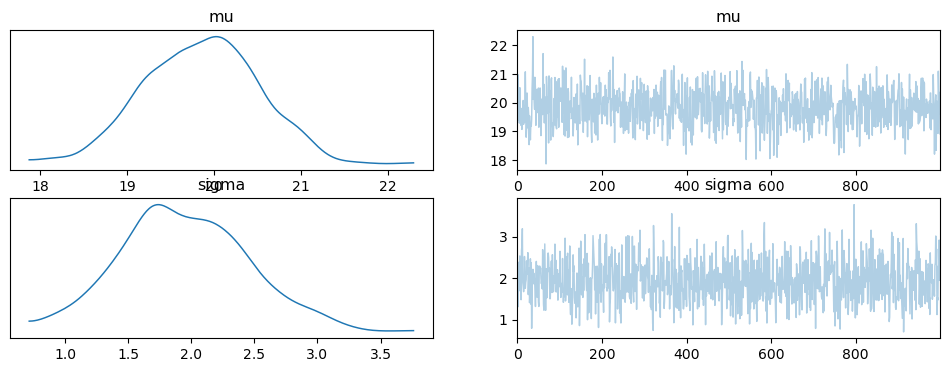

In [45]:

az.plot_trace(wildfire_avg_area_burnt_per_year_trace_norm)
plt.show()    

Mean from data: 19.874445409722224
Standard deviation from data: 1.5407255128154926
Mean from PyMC3: 19.84894651567399
Sigma from PyMC3: 1.9487878330243629
19.874445409722224 1.5407255128154926


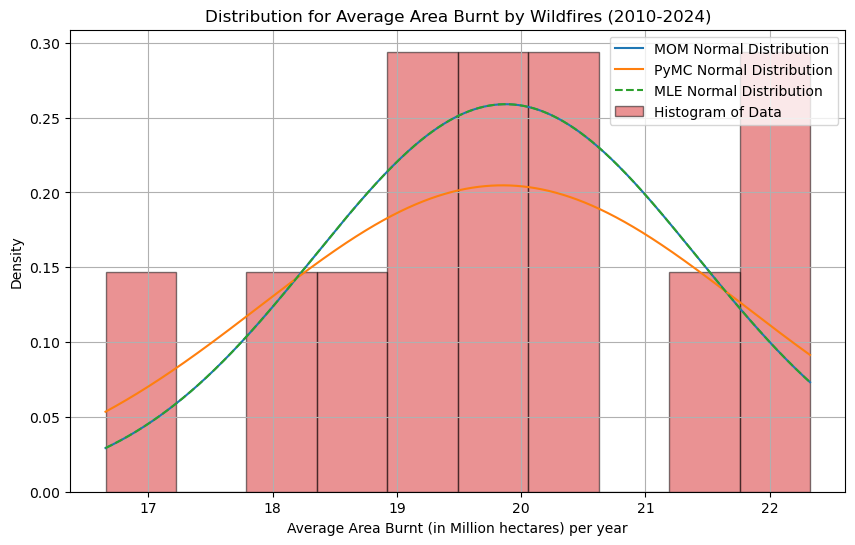

In [46]:

data = Avg_Wildfire_Area_Burnt_btw_2012_and_2023

# Calculate mean and standard deviation
l_mean = np.mean(data)
l_std = np.std(data)

wildfire_avg_area_burnt_per_year_trace_norm_mu = wildfire_avg_area_burnt_per_year_trace_norm['mu'].mean()
wildfire_avg_area_burnt_per_year_trace_norm_sigma = wildfire_avg_area_burnt_per_year_trace_norm['sigma'].mean()

print("Mean from data:", l_mean)
print("Standard deviation from data:", l_std)
print("Mean from PyMC3:", wildfire_avg_area_burnt_per_year_trace_norm_mu)
print("Sigma from PyMC3:", wildfire_avg_area_burnt_per_year_trace_norm_sigma)

# Set up a range of x values for the PDF plots
x = np.linspace(min(data), max(data), 1000)

# Normal Distribution using mean and std from data
y = norm.pdf(x, l_mean, l_std)

# Normal Distribution from PyMC3 results
pymc_norm_y = norm.pdf(x, wildfire_avg_area_burnt_per_year_trace_norm_mu, wildfire_avg_area_burnt_per_year_trace_norm_sigma)

# Fit a normal distribution using MLE
(mle_mu, mle_sigma) = norm.fit(data)
print(mle_mu, mle_sigma)
mle_norm_y = norm.pdf(x, mle_mu, mle_sigma)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='MOM Normal Distribution')
plt.plot(x, pymc_norm_y, label='PyMC Normal Distribution')
plt.plot(x, mle_norm_y, label='MLE Normal Distribution', linestyle='--')

# Plotting the histogram of the data
plt.hist(data, bins=10, edgecolor='black', density=True, alpha=0.5, label='Histogram of Data')

# Add titles and labels
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024)')
plt.xlabel('Average Area Burnt (in Million hectares) per year')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Mean from data: 33.31588890972221
# Standard deviation from data: 2.466448815566711
# Mean from PyMC3: 33.27506918535999
# Sigma from PyMC3: 3.122333125153424
# 33.31588890972221 2.466448815566711


In [47]:
# KS test for MOM
D_mom, p_mom = stats.kstest(data, 'norm', args=(l_mean, l_std))
print(f"MOM KS Statistic: {D_mom}, p-value: {p_mom}")

# KS test for MLE
D_mle, p_mle = stats.kstest(data, 'norm', args=(mle_mu, mle_sigma))
print(f"MLE KS Statistic: {D_mle}, p-value: {p_mle}")

# KS test for PyMC3
# Since PyMC3 parameters do not directly translate into scipy's CDF function, we need to manually apply the CDF
norm_dist_pymc = stats.norm(wildfire_avg_area_burnt_per_year_trace_norm_mu, wildfire_avg_area_burnt_per_year_trace_norm_sigma)
D_pymc, p_pymc = stats.kstest(data, lambda x: norm_dist_pymc.cdf(x))
print(f"PyMC3 KS Statistic: {D_pymc}, p-value: {p_pymc}")


MOM KS Statistic: 0.09772552693757924, p-value: 0.9990289068364864
MLE KS Statistic: 0.09772552693757924, p-value: 0.9990289068364864
PyMC3 KS Statistic: 0.13345727399838758, p-value: 0.9640963317841308


# MOM/MLE Suits better for modelling Average Area Burnt (in Million hectares) per year

In [48]:
import numpy as np

# print(len(Avg_Wildfire_Area_Burnt_btw_2012_and_2023))
# print(len(filtered_pm25_Emissons_in_year_rang_df))
# print((Avg_Wildfire_Area_Burnt_btw_2012_and_2023))
# print((filtered_pm25_Emissons_in_year_rang_df))
correlation_coefficient = np.corrcoef(Avg_Wildfire_Area_Burnt_btw_2012_and_2023,filtered_Co2_Emissions_btw_2012_and_2023_df )[0, 1]
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

Correlation coefficient: 0.63


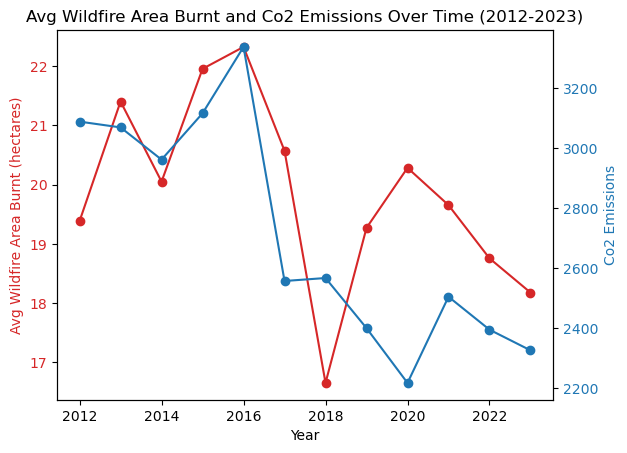

In [49]:
import matplotlib.pyplot as plt


# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plotting the Average Wildfire Area Burnt on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Wildfire Area Burnt (hectares)', color=color)
ax1.plot(year_range, Avg_Wildfire_Area_Burnt_btw_2012_and_2023, color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the PM2.5 emissions data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Co2 Emissions', color=color)  # we already handled the x-label with ax1
ax2.plot(year_range, filtered_Co2_Emissions_btw_2012_and_2023_df, color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title
plt.title('Avg Wildfire Area Burnt and Co2 Emissions Over Time (2012-2023)')

# Show the plot
plt.show()


/Users/saipranath/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


/Users/saipranath/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


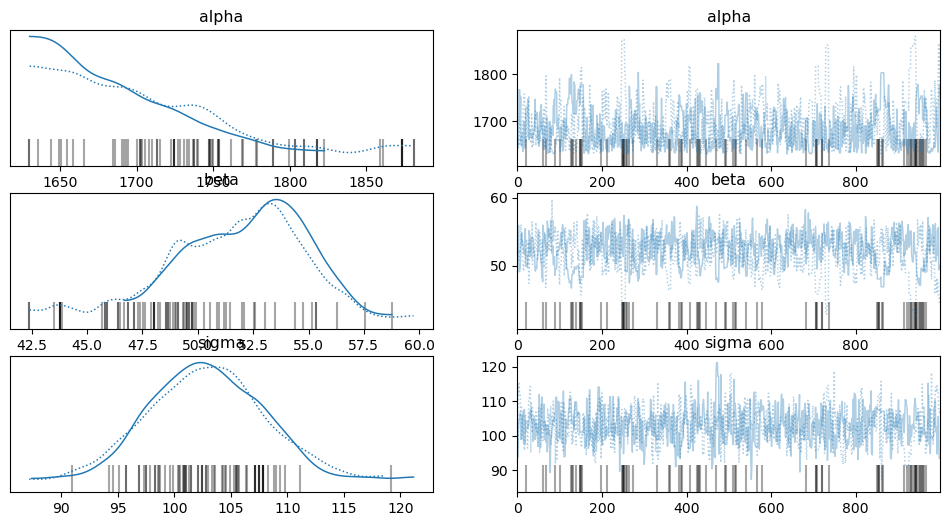

In [50]:

x_data = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)  # Predictor variable
y_data = np.array(filtered_Co2_Emissions_btw_2012_and_2023_df)   # Response variable 

alpha_lower = y_data.mean() - 3 * y_data.std()
alpha_upper = y_data.mean() + 3 * y_data.std()

beta_lower = -3 * np.abs(y_data / x_data).max()
beta_upper = 3 * np.abs(y_data / x_data).max()


with pm.Model() as normal_regression_model:
    # Priors for unknown model parameters using Uniform distribution
    alpha = pm.Uniform('alpha', lower=alpha_lower, upper=alpha_upper)
    beta = pm.Uniform('beta', lower=beta_lower, upper=beta_upper)
    
    # Standard deviation still uses a HalfNormal
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear regression model
    mu = alpha + beta * x_data

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_data)

    # Posterior sampling
    trace = pm.sample(1000, tune=2000, cores=1)

# Inspecting the trace with ArviZ
az.plot_trace(trace)
plt.show()


1691.4794138902607 51.998916140512


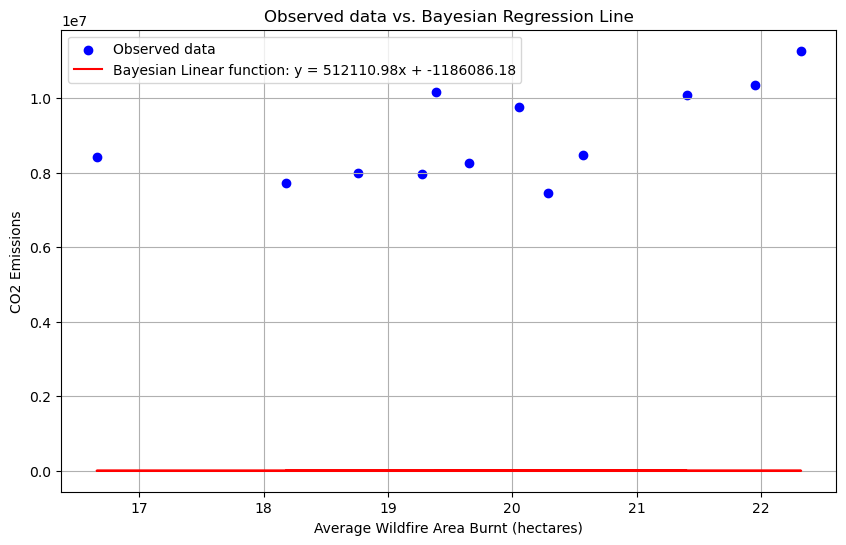

In [78]:
# Extract the mean of the posterior for alpha and beta
alpha_mean = np.mean(trace['alpha'])
beta_mean = np.mean(trace['beta'])
print(alpha_mean, beta_mean )
# Generate predictions for the regression line
y_pred = alpha_mean + beta_mean * x_data
y_pred_pymc = y_pred
# Plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Observed data')

# Plot the regression line
plt.plot(x_data, y_pred, color='red', label=f'Bayesian Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Add title and labels
plt.title('Observed data vs. Bayesian Regression Line')
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
from scipy import stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_Co2_Emissions_btw_2012_and_2023_df)
y_pred_linregress = intercept + slope * x_data
# Display the linear function
print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


Linear function: y = 146.50x + -199.26


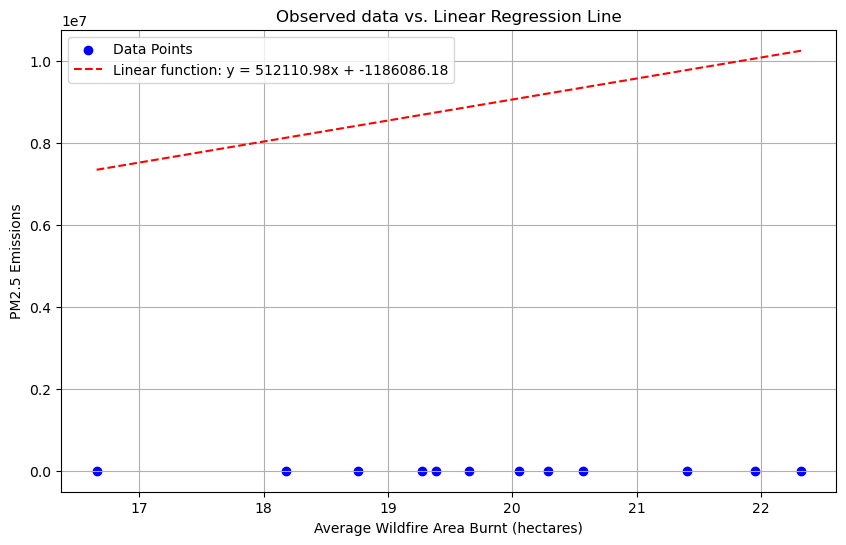

In [79]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_Co2_Emissions_btw_2012_and_2023_df, color='blue', label='Data Points')

# Adding labels and title
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('PM2.5 Emissions')
plt.title('Observed data vs. Linear Regression Line')

x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)

y_values = slope * x_values +intercept  # Linear equation

# Plot the line
plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Adding legend
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()


In [98]:
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(y_data, y_pred_pymc)
print(y_pred_pymc)
mse_2 = mean_squared_error(y_data, y_pred_linregress)
print(y_pred_linregress)

rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)

from sklearn.metrics import r2_score

r2_1 = r2_score(y_data, y_pred_pymc)
r2_2 = r2_score(y_data, y_pred_linregress)

from sklearn.metrics import mean_absolute_error

mae_1 = mean_absolute_error(y_data, y_pred_pymc)
mae_2 = mean_absolute_error(y_data, y_pred_linregress)




[2699.5252023  2804.43105699 2734.1270404  2833.09159426 2852.31824983
 2761.18755368 2557.52818707 2693.56613084 2746.21571375 2713.51654633
 2666.83539468 2636.80573895]
[2640.76069974 2936.31744247 2738.24626516 3017.06427081 3071.2325316
 2814.48526238 2240.70509346 2623.97189654 2772.3043159  2680.17924393
 2548.66199764 2464.05788036]


In [55]:
print(f"Function 1 - RMSE: {rmse_1}, R-squared: {r2_1}, MAE: {mae_1}")
print(f"Function 2 - RMSE: {rmse_2}, R-squared: {r2_2}, MAE: {mae_2}")

# Decide based on comparison
if rmse_1 < rmse_2 and r2_1 > r2_2:
    print("Function 1 fits better.")
elif rmse_2 < rmse_1 and r2_2 > r2_1:
    print("Function 2 fits better.")
else:
    print("Results are inconclusive or mixed; consider additional analysis.")


Function 1 - RMSE: 317.18821036537076, R-squared: 0.22726595847070696, MAE: 289.42328728371143
Function 2 - RMSE: 281.5148051835186, R-squared: 0.39130679824037296, MAE: 249.60899945703764
Function 2 fits better.


### Conclusion

Based on the derived relationship between CO2 emissions and the area burnt, we can define the equation as follows:

$$ \text{CO2_emission} = \text{area_burnt} \times 146.5 - 199.26 $$

This equation illustrates that CO2 emissions is directly proportional to the area burnt.  we conclude that a reduction in the area burnt by \(x\%\) leads to a corresponding \(x\%\) reduction in CO2 emissions.


## Area Burnt vs PM2.5 Emissions

In [91]:

correlation_coefficient = np.corrcoef(Avg_Wildfire_Area_Burnt_btw_2012_and_2023,filtered_pm25_Emissons_in_year_rang_df )[0, 1]
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

Correlation coefficient: 0.65


In [92]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df)

# Display the linear function
print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


Linear function: y = 512110.98x + -1186086.18


In [93]:
# import numpy as np
# import pandas as pd
# from scipy import stats

# # Convert data to numpy arrays
# x_data = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
# y_data = np.array(filtered_pm25_Emissons_in_year_rang_df)

# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

# # Display the linear function
# print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')
# print(f'Correlation coefficient: {r_value:.2f}')


In [94]:
# import pymc3 as pm
# import arviz as az

# # Define the model with adjusted priors and initialization
# with pm.Model() as normal_regression_model:
#     # Priors for unknown model parameters
#     alpha = pm.Normal('alpha', mu=0, sigma=10)
#     beta = pm.Normal('beta', mu=0, sigma=10)
#     sigma = pm.HalfNormal('sigma', sigma=1)

#     # Expected value of the outcome
#     mu = alpha + beta * x_data

#     # Likelihood (sampling distribution) of observations
#     Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_data)

#     # Posterior sampling with improved tuning settings
#     trace = pm.sample(1000, tune=2000, cores=1, chains=2, init='adapt_full')

# # Plot trace and summary statistics
# az.plot_trace(trace)
# az.summary(trace)


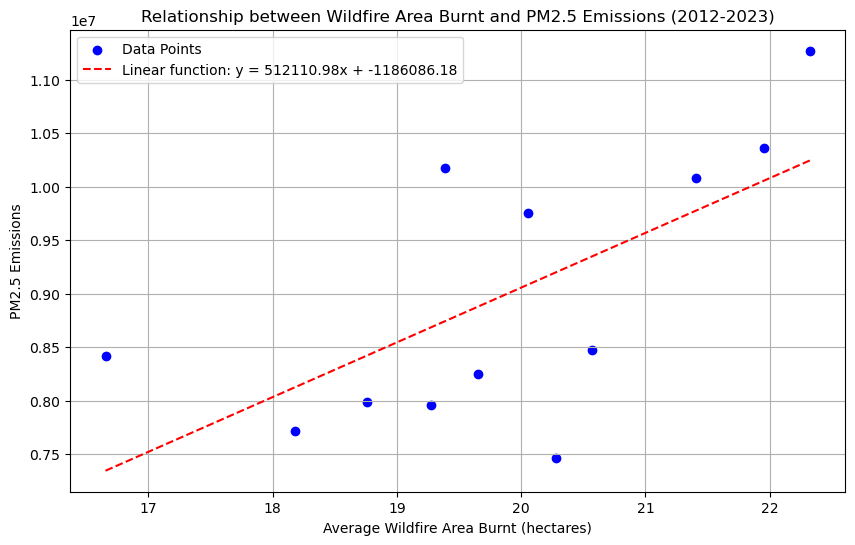

In [95]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df, color='blue', label='Data Points')

# Adding labels and title
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('PM2.5 Emissions')
plt.title('Relationship between Wildfire Area Burnt and PM2.5 Emissions (2012-2023)')

# Linear function line based on the given equation
# Define the x range based on your data
x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)
y_values = slope * x_values + intercept # Linear equation

# Plot the line
plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Adding legend
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()


/Users/saipranath/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/saipranath/anaconda3/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
There were 607 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 1.0, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model

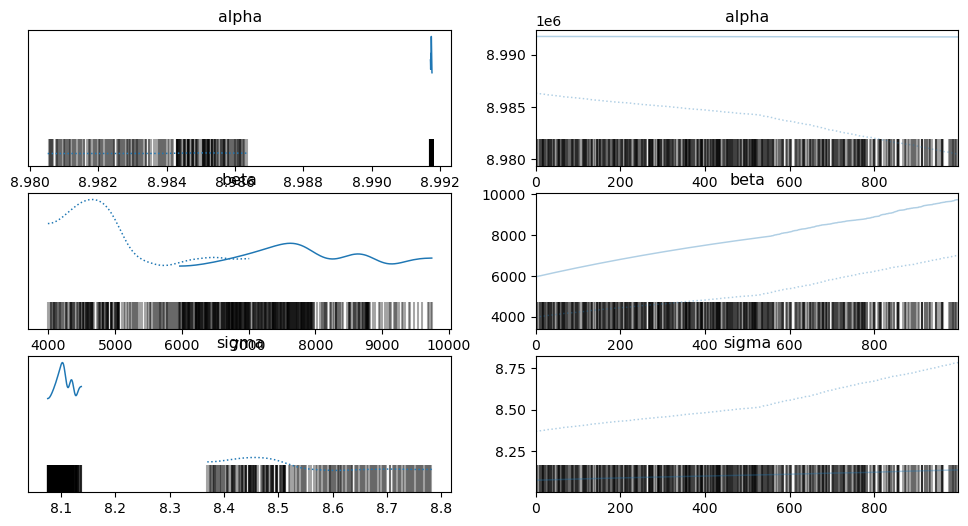

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8987807.538,4110.598,8981425.680,8991763.949,2867.668,2415.644,2.0,11.0,3.04
beta,6565.012,1613.558,3994.056,9294.383,1090.045,905.876,2.0,11.0,2.81
sigma,8.325,0.234,8.076,8.717,0.163,0.137,2.0,11.0,3.04


In [99]:

x_data = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)  # Predictor variable
y_data = np.array(filtered_pm25_Emissons_in_year_rang_df)   # Response variable 

alpha_lower = y_data.mean() - 3 * y_data.std()
alpha_upper = y_data.mean() + 3 * y_data.std()

beta_lower = -3 * np.abs(y_data / x_data).max()
beta_upper = 3 * np.abs(y_data / x_data).max()


with pm.Model() as normal_regression_model:
    # Priors for unknown model parameters using Uniform distribution
    alpha = pm.Uniform('alpha', lower=alpha_lower, upper=alpha_upper)
    beta = pm.Uniform('beta', lower=beta_lower, upper=beta_upper)
    
    # Standard deviation still uses a HalfNormal
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear regression model
    mu = alpha + beta * x_data

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_data)

    # Posterior sampling
    trace = pm.sample(1000,tune=2000, cores=1, chains=2, init='adapt_full')

# Inspecting the trace with ArviZ
az.plot_trace(trace)
plt.show()
az.summary(trace)

8987807.537549812 6565.01154937636


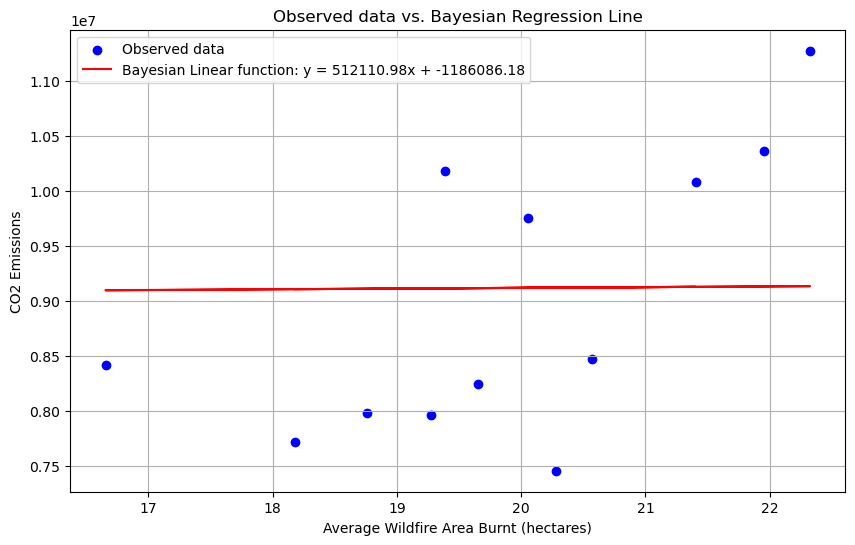

In [100]:
# Extract the mean of the posterior for alpha and beta
alpha_mean = np.mean(trace['alpha'])
beta_mean = np.mean(trace['beta'])
print(alpha_mean, beta_mean )
# Generate predictions for the regression line
y_pred = alpha_mean + beta_mean * x_data
y_pred_pymc = y_pred
# Plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Observed data')

# Plot the regression line
plt.plot(x_data, y_pred, color='red', label=f'Bayesian Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Add title and labels
plt.title('Observed data vs. Bayesian Regression Line')
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()


In [101]:
from scipy import stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df)
y_pred_linregress = intercept + slope * x_data
# Display the linear function
print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


Linear function: y = 512110.98x + -1186086.18


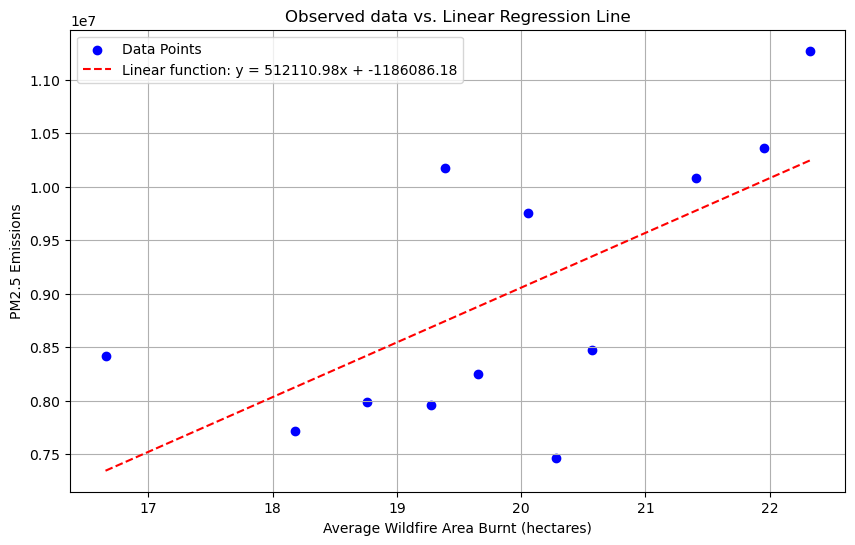

In [102]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df, color='blue', label='Data Points')

# Adding labels and title
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('PM2.5 Emissions')
plt.title('Observed data vs. Linear Regression Line')

x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)

y_values = slope * x_values +intercept  # Linear equation

# Plot the line
plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Adding legend
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()


In [103]:
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(y_data, y_pred_pymc)
print(y_pred_pymc)
mse_2 = mean_squared_error(y_data, y_pred_linregress)
print(y_pred_linregress)

rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)

from sklearn.metrics import r2_score

r2_1 = r2_score(y_data, y_pred_pymc)
r2_2 = r2_score(y_data, y_pred_linregress)

from sklearn.metrics import mean_absolute_error

mae_1 = mean_absolute_error(y_data, y_pred_pymc)
mae_2 = mean_absolute_error(y_data, y_pred_linregress)




[9115076.19494487 9128320.85846363 9119444.77574605 9131939.33308103
 9134366.75321351 9122861.24276974 9097148.66656244 9114323.84516839
 9120971.00525437 9116842.64205537 9110949.01344795 9107157.68371771]
[ 8741646.03237174  9774810.64121274  9082422.00363336 10057073.75098464
 10246427.33993093  9348927.28790489  7343189.37679323  8682958.15695526
  9201477.22241908  8879439.69057823  8419700.68050696  8123953.81670893]


In [104]:
print(f"Function 1 - RMSE: {rmse_1}, R-squared: {r2_1}, MAE: {mae_1}")
print(f"Function 2 - RMSE: {rmse_2}, R-squared: {r2_2}, MAE: {mae_2}")

# Decide based on comparison
if rmse_1 < rmse_2 and r2_1 > r2_2:
    print("Function 1 fits better.")
elif rmse_2 < rmse_1 and r2_2 > r2_1:
    print("Function 2 fits better.")
else:
    print("Results are inconclusive or mixed; consider additional analysis.")


Function 1 - RMSE: 1205962.6972351552, R-squared: -8.9169534396083e-05, MAE: 1128627.3486272397
Function 2 - RMSE: 911953.9076626243, R-squared: 0.42810440368489333, MAE: 802419.309178892
Function 2 fits better.


## Conclusion:

Root Mean Squared Error (RMSE): Function 2 (linear regression) has a lower RMSE (911953.91) compared to Function 1 (Bayesian regression) (1205962.70). A lower RMSE indicates better performance in terms of how well the model's predictions align with the actual data. Therefore, Function 2 performs better in this aspect.

R-squared (R2): Function 2 (linear regression) has a higher R-squared value (0.428) compared to Function 1 (Bayesian regression) (-8.92e-05). R-squared represents the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A higher R-squared value indicates that more variance is explained by the model. Therefore, Function 2 performs better in terms of explaining the variance in the data.

Mean Absolute Error (MAE): Function 2 (linear regression) has a lower MAE (802419.31) compared to Function 1 (Bayesian regression) (1128627.35). MAE represents the average magnitude of the errors in a set of predictions, without considering their direction. A lower MAE indicates better accuracy of the model's predictions. Therefore, Function 2 performs better in terms of accuracy.

Based on these metrics, Function 2 (linear regression) outperforms Function 1 (Bayesian regression) in terms of RMSE, R-squared, and MAE. Therefore, we can conclude that the linear regression model fits the data better than the Bayesian regression model for area burnt vs pm2.5 emissions.

In [ ]:
# import statsmodels.api as sm

# # Add a constant to the input data to include the intercept in the model
# x_with_const = sm.add_constant(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)

# # Create a model and fit it
# model = sm.OLS(filtered_pm25_Emissons_in_year_rang_df, x_with_const)
# results = model.fit()

# # Print the summary of the regression
# print(results.summary())


In [ ]:

# # Create a scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_Co2_Emissions_btw_2012_and_2023_df, color='blue', label='Data Points')

# # Adding labels and title
# plt.xlabel('Average Wildfire Area Burnt (hectares)')
# plt.ylabel('PM2.5 Emissions')
# plt.title('Relationship between Wildfire Area Burnt and PM2.5 Emissions (2012-2023)')

# # Linear function line based on the given equation
# # Define the x range based on your data
# x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)
# y_values = 213.57 * x_values -1031.29  # Linear equation

# # Plot the line
# plt.plot(x_values, y_values, "r--", label='Linear Fit: $y = 1037290.17x - 7663379.35$')

# # Adding legend
# plt.legend()

# # Show the plot with grid
# plt.grid(True)
# plt.show()


In [105]:

correlation_coefficient = np.corrcoef(filtered_pm25_Emissons_in_year_rang_df,filtered_Co2_Emissions_btw_2012_and_2023_df)[0, 1]
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

Correlation coefficient: 1.00


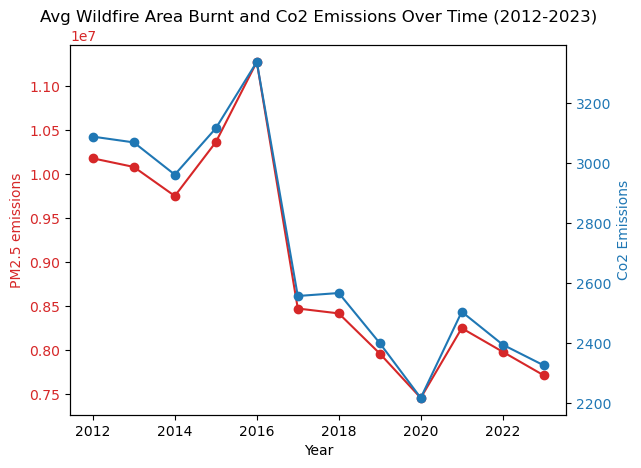

In [63]:
import matplotlib.pyplot as plt


# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plotting the Average Wildfire Area Burnt on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('PM2.5 emissions', color=color)
ax1.plot(year_range, filtered_pm25_Emissons_in_year_rang_df, color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the PM2.5 emissions data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Co2 Emissions', color=color)  # we already handled the x-label with ax1
ax2.plot(year_range, filtered_Co2_Emissions_btw_2012_and_2023_df, color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title
plt.title('Avg Wildfire Area Burnt and Co2 Emissions Over Time (2012-2023)')

# Show the plot
plt.show()


In [107]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_Co2_Emissions_btw_2012_and_2023_df, filtered_pm25_Emissons_in_year_rang_df)

# Display the linear function
print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


Linear function: y = 3333.82x + -50580.70


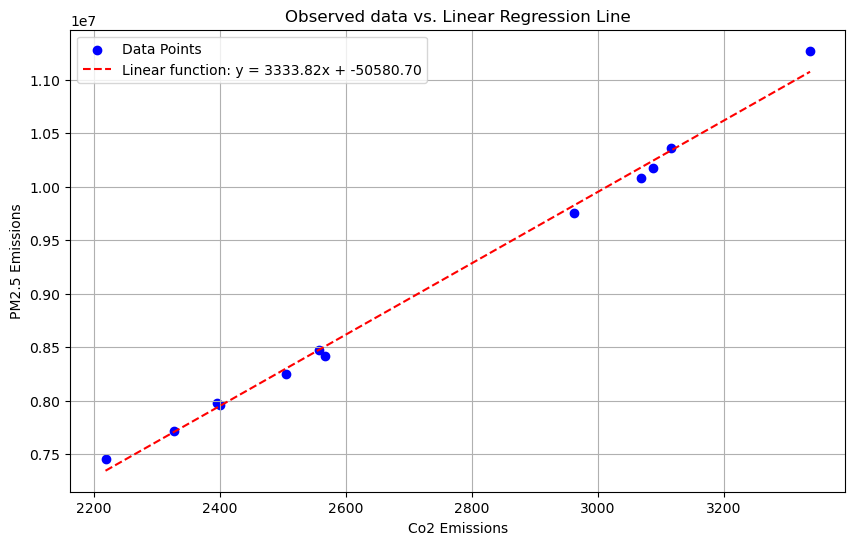

In [112]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_Co2_Emissions_btw_2012_and_2023_df, filtered_pm25_Emissons_in_year_rang_df, color='blue', label='Data Points')

# Adding labels and title
plt.xlabel('Co2 Emissions')
plt.ylabel('PM2.5 Emissions')
plt.title('Observed data vs. Linear Regression Line')

x_values = np.linspace(min(filtered_Co2_Emissions_btw_2012_and_2023_df), max(filtered_Co2_Emissions_btw_2012_and_2023_df), 100)

y_values = slope * x_values +intercept  # Linear equation

# Plot the line
plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Adding legend
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()
